### Imports

In [1]:
#official libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import time 
import visdom
from os.path import expanduser

In [2]:
#own files
from lib.utils_general import diff_same_length, get_data_paths
from lib.utils_generate_W import get_grid, gauss_dist, generate_W
from lib.utils_generate_n import n_compl, plot_n
from lib.utils_calc_psi import plot_psi
from lib.utils_generate_data import generate_init_data, generate_init_data_diverse, \
                                    plot_sample, generate_corr_data, generate_init_data_diverse_wavelendist
from lib.utils_initial_dataset import InitialDataset, ToTensor, OneChannel, Normalize, calc_mean_std
from lib.utils_train import get_dataloaders, train_net
from lib.nets import FNN, UNet
from lib.utils_evaluation import DeNorm, plot_prediction, plot_correction
from lib.utils_corrector_dataset import CorrectorDataset, NormalizeCorr, calc_mean_std_corr, ToDevice
from lib.utils_train_corrector import train_corrector
from lib.UNet_featurek import UNet_featurek
from lib.LSTM import LSTM
from lib.plot_intensity_bars import plot_intensity_bars
from lib.LSTMFFout import LSTMFFout

In [3]:
torch.cuda.is_available()

True

### Parameter, paths, etc

In [10]:
# ---------------------------------
# choose which mode the prg is in:
# ---------------------------------
do_load_model = False
#do_load_model_corr = False
do_train_model = True  # not do_load_model
#do_train_model_corr = not do_load_model_corr
do_create_initial_data = True
do_create_test_data = True
#do_create_corrector_data = True
toy_data = False #if run on GPU machine, set to false
which_model = 'LSTM' #FNN / UNet / UNet_old / UNet_featurek / LSTM
#which_model_corr = 'UNet'
# ---------------------------------

# ---------------------------------
# paths:
# ---------------------------------
home = expanduser("~")

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# models
path_model = 'models/' + which_model + '.pt'
path_model_corr = 'models/' + which_model + '_corr.pt'

# data
path_initial_data, path_corrector_data = get_data_paths(toy_data, device, home)

path_initial_data_diverse = home + '/ml_data/data_initial_diverse_wavelendist/'
path_test_data = home + '/ml_data/data_test_wavelendist/'

# plots
path_plots = 'plots/'
# ---------------------------------

# ---------------------------------
# hyperparameters:
# ---------------------------------
learning_rate = 0.0001 # for UNet: 0.000001
nmbr_epochs = 100
early_stopping = 100
validation_split = 0.2
# ---------------------------------

# ---------------------------------
# data parameters:
# ---------------------------------
half_width = 5
nmbr_points = 10000
if toy_data:
    size_dataset = 8 #if run on GPU machine, set to 5000 (toydata 8)
else:
    size_dataset = 20000

grid, stepsize = get_grid(half_width, nmbr_points)
# ---------------------------------

### Generate Initial Data

In [11]:
if do_create_initial_data:
    generate_init_data_diverse_wavelendist(size_dataset, path = path_initial_data_diverse, x = grid, dx = stepsize)

Generating Pot Nmbr  0 , Runtime since last:  0.12163925170898438 , Runtime so far:  0.12163901329040527
Generating Pot Nmbr  300 , Runtime since last:  18.438554048538208 , Runtime so far:  18.560193300247192
Generating Pot Nmbr  600 , Runtime since last:  18.68776845932007 , Runtime so far:  37.24796199798584
Generating Pot Nmbr  900 , Runtime since last:  18.009491205215454 , Runtime so far:  55.25745368003845
Generating Pot Nmbr  1200 , Runtime since last:  17.376280307769775 , Runtime so far:  72.63373374938965
Generating Pot Nmbr  1500 , Runtime since last:  17.50537085533142 , Runtime so far:  90.13910484313965
Generating Pot Nmbr  1800 , Runtime since last:  18.27610683441162 , Runtime so far:  108.41521167755127
Generating Pot Nmbr  2100 , Runtime since last:  17.983999490737915 , Runtime so far:  126.39921140670776
Generating Pot Nmbr  2400 , Runtime since last:  17.532875537872314 , Runtime so far:  143.93208694458008
Generating Pot Nmbr  2700 , Runtime since last:  17.90587

Generating Pot Nmbr  23400 , Runtime since last:  17.305646896362305 , Runtime so far:  1369.082139492035
Generating Pot Nmbr  23700 , Runtime since last:  17.215287923812866 , Runtime so far:  1386.2974271774292
Generating Pot Nmbr  24000 , Runtime since last:  17.38198161125183 , Runtime so far:  1403.6794092655182
Generating Pot Nmbr  24300 , Runtime since last:  16.781883716583252 , Runtime so far:  1420.4612929821014
Generating Pot Nmbr  24600 , Runtime since last:  16.881639003753662 , Runtime so far:  1437.342931985855
Generating Pot Nmbr  24900 , Runtime since last:  17.25351333618164 , Runtime so far:  1454.596445798874
Generating Pot Nmbr  25200 , Runtime since last:  17.12369132041931 , Runtime so far:  1471.7201371192932
Generating Pot Nmbr  25500 , Runtime since last:  17.97688364982605 , Runtime so far:  1489.6970212459564
Generating Pot Nmbr  25800 , Runtime since last:  18.308061838150024 , Runtime so far:  1508.005083322525
Generating Pot Nmbr  26100 , Runtime since la

Generating Pot Nmbr  46800 , Runtime since last:  17.417954444885254 , Runtime so far:  2720.681890964508
Generating Pot Nmbr  47100 , Runtime since last:  16.619290828704834 , Runtime so far:  2737.30118227005
Generating Pot Nmbr  47400 , Runtime since last:  17.459797859191895 , Runtime so far:  2754.760980129242
Generating Pot Nmbr  47700 , Runtime since last:  17.000223398208618 , Runtime so far:  2771.761203765869
Generating Pot Nmbr  48000 , Runtime since last:  17.184220552444458 , Runtime so far:  2788.9454247951508
Generating Pot Nmbr  48300 , Runtime since last:  17.883426427841187 , Runtime so far:  2806.8288514614105
Generating Pot Nmbr  48600 , Runtime since last:  17.1439049243927 , Runtime so far:  2823.972756385803
Generating Pot Nmbr  48900 , Runtime since last:  18.098139762878418 , Runtime so far:  2842.0708963871
Generating Pot Nmbr  49200 , Runtime since last:  17.7937068939209 , Runtime so far:  2859.864603996277
Generating Pot Nmbr  49500 , Runtime since last:  1

6491


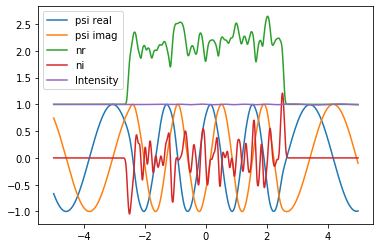

In [13]:
#show that it worked
plot_sample(size_dataset, path = path_initial_data_diverse, x = grid, dx = stepsize)

### Create Initial Dataset

In [14]:
nr_mean, nr_std, ni_mean, ni_std = calc_mean_std(size_dataset, path_initial_data_diverse)

In [15]:
transform = transforms.Compose([Normalize((nr_mean, ni_mean), (nr_std, ni_std)),
                                    ToTensor(device)
                                   ])

In [16]:
initial_dataset = InitialDataset(csv_file = path_initial_data_diverse + 'k_values.csv', 
                               root_dir = path_initial_data_diverse,
                               transform = transform)

In [17]:
len(initial_dataset)

60000

tensor([21.2786, -1.0210, -1.0210,  ..., -1.0210, -1.0210, -1.0210],
       device='cuda:0')
torch.Size([10001])
True


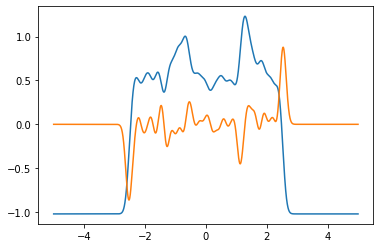

In [18]:
#show that it worked
idx = 3

print(initial_dataset[idx]['k_n_r'])
print(initial_dataset[idx]['k_n_r'].size())
print(initial_dataset[idx]['k_n_r'].is_cuda)

plt.plot(grid,initial_dataset[idx]['k_n_r'].cpu().numpy()[1:])
plt.plot(grid,initial_dataset[idx]['n_i'].cpu().numpy())    

### Create Dataloaders and Model

In [19]:
train_loader, validation_loader = get_dataloaders(initial_dataset, 
                                                  batch_size = 64, 
                                                  validation_split = validation_split, 
                                                  shuffle_dataset = True, 
                                                  random_seed= 42)

In [20]:
#evtl soll nicht ein neues Model erstellt, sondern ein altes geladen werden!

if do_load_model:
    model = torch.load(path_model, map_location=device) # , map_location=device
else:
    #sonst wird jetzt neues Model erstellt
    if which_model == 'FNN':
        model = FNN(n_feature=10001, n_hidden=1000, n_output=10000)
    elif which_model == 'UNet_featurek':
        model = UNet_featurek(device, n_channels=1, n_classes=1, label_len = nmbr_points)
    elif which_model == 'LSTM':
        #model = LSTM(10, 100, 3, 1000, device)
        model = LSTM(10, 200, 3, 1000, device)
    else:
        model = UNet(n_channels=1, n_classes=1, label_len = nmbr_points)

print(model)

LSTM(
  (lstm): LSTM(11, 200, num_layers=3, batch_first=True)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)


In [21]:
model.to(device)
next(model.parameters()).is_cuda

True

### Training

In [22]:
if do_train_model:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model, info = train_net(nmbr_epochs, model, criterion, optimizer,
                            train_loader, validation_loader, early_stopping= early_stopping, path=path_model)

[1,     1] loss: 7.206 runtime: 0.182615
[1,    11] loss: 90.232 runtime: 2.048162
[1,    21] loss: 93.526 runtime: 3.912578
[1,    31] loss: 93.737 runtime: 5.731150
[1,    41] loss: 87.791 runtime: 7.612344
[1,    51] loss: 99.459 runtime: 9.430151
[1,    61] loss: 103.863 runtime: 11.241352
[1,    71] loss: 89.698 runtime: 13.062163
[1,    81] loss: 96.364 runtime: 14.871834
[1,    91] loss: 88.332 runtime: 16.684540
[1,   101] loss: 76.039 runtime: 18.476932
[1,   111] loss: 90.519 runtime: 20.274376
[1,   121] loss: 69.510 runtime: 22.086863
[1,   131] loss: 87.690 runtime: 23.906287
[1,   141] loss: 73.815 runtime: 25.721516
[1,   151] loss: 70.163 runtime: 27.520435
[1,   161] loss: 65.091 runtime: 29.345719
[1,   171] loss: 62.598 runtime: 31.165866
[1,   181] loss: 52.731 runtime: 32.970696
[1,   191] loss: 61.099 runtime: 34.770021
[1,   201] loss: 50.763 runtime: 36.566186
[1,   211] loss: 41.781 runtime: 38.362809
[1,   221] loss: 45.301 runtime: 40.176566
[1,   231] loss: 

[3,   361] loss: 9.766 runtime: 506.190146
[3,   371] loss: 10.246 runtime: 507.993349
[3,   381] loss: 10.178 runtime: 509.801885
[3,   391] loss: 9.000 runtime: 511.615634
[3,   401] loss: 9.942 runtime: 513.425296
[3,   411] loss: 7.779 runtime: 515.238424
[3,   421] loss: 10.815 runtime: 517.052047
[3,   431] loss: 8.397 runtime: 518.856772
[3,   441] loss: 8.662 runtime: 520.658447
[3,   451] loss: 10.096 runtime: 522.449509
[3,   461] loss: 10.147 runtime: 524.258494
[3,   471] loss: 8.499 runtime: 526.059745
[3,   481] loss: 8.590 runtime: 527.865562
[3,   491] loss: 9.368 runtime: 529.665273
[3,   501] loss: 10.696 runtime: 531.476030
[3,   511] loss: 10.715 runtime: 533.287416
[3,   521] loss: 8.819 runtime: 535.089085
[3,   531] loss: 8.109 runtime: 536.908735
[3,   541] loss: 10.773 runtime: 538.702186
[3,   551] loss: 10.688 runtime: 540.510096
[3,   561] loss: 8.776 runtime: 542.327026
[3,   571] loss: 7.894 runtime: 544.126680
[3,   581] loss: 10.782 runtime: 545.936993
[

[5,   721] loss: 11.221 runtime: 1011.221416
[5,   731] loss: 11.622 runtime: 1013.029831
[5,   741] loss: 9.513 runtime: 1014.841416
Epoch 5 has validation loss 10.84975829910725
[6,     1] loss: 9.254 runtime: 1100.773680
[6,    11] loss: 10.153 runtime: 1102.630884
[6,    21] loss: 11.577 runtime: 1104.471166
[6,    31] loss: 10.526 runtime: 1106.277869
[6,    41] loss: 10.748 runtime: 1108.094339
[6,    51] loss: 10.087 runtime: 1109.898024
[6,    61] loss: 9.774 runtime: 1111.698642
[6,    71] loss: 8.422 runtime: 1113.503638
[6,    81] loss: 9.567 runtime: 1115.321070
[6,    91] loss: 9.841 runtime: 1117.118608
[6,   101] loss: 11.407 runtime: 1118.924360
[6,   111] loss: 10.171 runtime: 1120.746267
[6,   121] loss: 8.958 runtime: 1122.558599
[6,   131] loss: 9.386 runtime: 1124.372324
[6,   141] loss: 8.310 runtime: 1126.185403
[6,   151] loss: 10.994 runtime: 1128.069710
[6,   161] loss: 8.684 runtime: 1129.927686
[6,   171] loss: 9.558 runtime: 1131.768465
[6,   181] loss: 10.

[8,   301] loss: 5.498 runtime: 1595.026447
[8,   311] loss: 6.657 runtime: 1596.826466
[8,   321] loss: 6.296 runtime: 1598.633944
[8,   331] loss: 6.006 runtime: 1600.432707
[8,   341] loss: 7.756 runtime: 1602.239704
[8,   351] loss: 7.994 runtime: 1604.053490
[8,   361] loss: 7.707 runtime: 1605.869094
[8,   371] loss: 9.821 runtime: 1607.677333
[8,   381] loss: 6.897 runtime: 1609.478097
[8,   391] loss: 7.225 runtime: 1611.279588
[8,   401] loss: 6.800 runtime: 1613.088086
[8,   411] loss: 6.350 runtime: 1614.895922
[8,   421] loss: 7.379 runtime: 1616.732728
[8,   431] loss: 5.586 runtime: 1618.546695
[8,   441] loss: 6.939 runtime: 1620.363979
[8,   451] loss: 6.858 runtime: 1622.175978
[8,   461] loss: 6.605 runtime: 1623.978757
[8,   471] loss: 5.846 runtime: 1625.843098
[8,   481] loss: 4.957 runtime: 1627.651289
[8,   491] loss: 5.424 runtime: 1629.438539
[8,   501] loss: 6.281 runtime: 1631.242942
[8,   511] loss: 4.369 runtime: 1633.062000
[8,   521] loss: 5.754 runtime: 

[10,   631] loss: 4.028 runtime: 2094.747839
[10,   641] loss: 4.221 runtime: 2096.558252
[10,   651] loss: 5.296 runtime: 2098.341514
[10,   661] loss: 4.313 runtime: 2100.146419
[10,   671] loss: 3.819 runtime: 2101.951510
[10,   681] loss: 4.155 runtime: 2103.762379
[10,   691] loss: 3.763 runtime: 2105.571116
[10,   701] loss: 3.979 runtime: 2107.417334
[10,   711] loss: 3.967 runtime: 2109.231410
[10,   721] loss: 5.613 runtime: 2111.042120
[10,   731] loss: 6.764 runtime: 2112.850713
[10,   741] loss: 4.582 runtime: 2114.664100
Epoch 10 has validation loss 3.8250448710106775
MODEL SAVED.
[11,     1] loss: 3.494 runtime: 2200.513658
[11,    11] loss: 3.074 runtime: 2202.363444
[11,    21] loss: 4.268 runtime: 2204.161808
[11,    31] loss: 3.925 runtime: 2205.949098
[11,    41] loss: 6.219 runtime: 2207.756581
[11,    51] loss: 5.221 runtime: 2209.567777
[11,    61] loss: 3.916 runtime: 2211.373393
[11,    71] loss: 3.306 runtime: 2213.201298
[11,    81] loss: 5.531 runtime: 2215.0

[13,   171] loss: 4.673 runtime: 2671.545048
[13,   181] loss: 3.941 runtime: 2673.363906
[13,   191] loss: 5.346 runtime: 2675.175417
[13,   201] loss: 4.668 runtime: 2676.982773
[13,   211] loss: 5.294 runtime: 2678.790641
[13,   221] loss: 5.589 runtime: 2680.590672
[13,   231] loss: 5.400 runtime: 2682.392077
[13,   241] loss: 3.795 runtime: 2684.192461
[13,   251] loss: 4.225 runtime: 2686.002293
[13,   261] loss: 5.077 runtime: 2687.825032
[13,   271] loss: 4.894 runtime: 2689.661965
[13,   281] loss: 4.251 runtime: 2691.601250
[13,   291] loss: 4.103 runtime: 2693.435543
[13,   301] loss: 4.908 runtime: 2695.263964
[13,   311] loss: 4.692 runtime: 2697.103611
[13,   321] loss: 4.655 runtime: 2698.992484
[13,   331] loss: 4.572 runtime: 2700.834355
[13,   341] loss: 4.941 runtime: 2702.646080
[13,   351] loss: 4.216 runtime: 2704.457880
[13,   361] loss: 3.726 runtime: 2706.264562
[13,   371] loss: 4.275 runtime: 2708.081483
[13,   381] loss: 4.709 runtime: 2709.872771
[13,   391

[15,   471] loss: 3.210 runtime: 3166.306721
[15,   481] loss: 1.710 runtime: 3168.126707
[15,   491] loss: 1.834 runtime: 3169.945807
[15,   501] loss: 1.569 runtime: 3171.758727
[15,   511] loss: 2.387 runtime: 3173.567092
[15,   521] loss: 2.472 runtime: 3175.371841
[15,   531] loss: 2.884 runtime: 3177.173763
[15,   541] loss: 1.931 runtime: 3178.981896
[15,   551] loss: 4.369 runtime: 3180.775955
[15,   561] loss: 4.270 runtime: 3182.582576
[15,   571] loss: 3.555 runtime: 3184.383945
[15,   581] loss: 2.747 runtime: 3186.191271
[15,   591] loss: 3.989 runtime: 3188.002987
[15,   601] loss: 3.197 runtime: 3189.810014
[15,   611] loss: 2.112 runtime: 3191.616150
[15,   621] loss: 2.608 runtime: 3193.413336
[15,   631] loss: 2.082 runtime: 3195.215544
[15,   641] loss: 2.038 runtime: 3197.014702
[15,   651] loss: 1.667 runtime: 3198.820409
[15,   661] loss: 2.480 runtime: 3200.630176
[15,   671] loss: 2.472 runtime: 3202.432612
[15,   681] loss: 2.606 runtime: 3204.229429
[15,   691

[18,    11] loss: 1.787 runtime: 3745.418763
[18,    21] loss: 1.923 runtime: 3747.223250
[18,    31] loss: 1.841 runtime: 3749.030824
[18,    41] loss: 2.128 runtime: 3750.849649
[18,    51] loss: 3.061 runtime: 3752.656280
[18,    61] loss: 2.503 runtime: 3754.463522
[18,    71] loss: 2.149 runtime: 3756.266262
[18,    81] loss: 2.037 runtime: 3758.075693
[18,    91] loss: 2.424 runtime: 3759.884216
[18,   101] loss: 2.693 runtime: 3761.689678
[18,   111] loss: 1.962 runtime: 3763.492196
[18,   121] loss: 2.040 runtime: 3765.293953
[18,   131] loss: 2.002 runtime: 3767.104456
[18,   141] loss: 1.480 runtime: 3768.910912
[18,   151] loss: 3.746 runtime: 3770.711230
[18,   161] loss: 4.149 runtime: 3772.514548
[18,   171] loss: 3.925 runtime: 3774.320570
[18,   181] loss: 3.777 runtime: 3776.132051
[18,   191] loss: 3.651 runtime: 3777.933782
[18,   201] loss: 2.971 runtime: 3779.741892
[18,   211] loss: 3.287 runtime: 3781.546645
[18,   221] loss: 2.794 runtime: 3783.352756
[18,   231

[20,   311] loss: 2.089 runtime: 4240.129049
[20,   321] loss: 1.672 runtime: 4241.942754
[20,   331] loss: 2.972 runtime: 4243.753748
[20,   341] loss: 1.964 runtime: 4245.574293
[20,   351] loss: 1.905 runtime: 4247.389493
[20,   361] loss: 2.274 runtime: 4249.192872
[20,   371] loss: 2.139 runtime: 4251.001770
[20,   381] loss: 1.510 runtime: 4252.799573
[20,   391] loss: 1.613 runtime: 4254.612436
[20,   401] loss: 1.871 runtime: 4256.423387
[20,   411] loss: 2.920 runtime: 4258.229232
[20,   421] loss: 2.514 runtime: 4260.042352
[20,   431] loss: 2.551 runtime: 4261.845758
[20,   441] loss: 2.157 runtime: 4263.678986
[20,   451] loss: 1.963 runtime: 4265.480741
[20,   461] loss: 1.451 runtime: 4267.281774
[20,   471] loss: 1.287 runtime: 4269.082400
[20,   481] loss: 1.704 runtime: 4270.888559
[20,   491] loss: 1.376 runtime: 4272.698776
[20,   501] loss: 2.034 runtime: 4274.510256
[20,   511] loss: 2.408 runtime: 4276.315873
[20,   521] loss: 2.721 runtime: 4278.155995
[20,   531

[22,   611] loss: 2.385 runtime: 4734.433278
[22,   621] loss: 2.146 runtime: 4736.284565
[22,   631] loss: 1.477 runtime: 4738.094657
[22,   641] loss: 1.291 runtime: 4739.926666
[22,   651] loss: 1.369 runtime: 4741.719184
[22,   661] loss: 1.492 runtime: 4743.533602
[22,   671] loss: 1.734 runtime: 4745.349373
[22,   681] loss: 1.850 runtime: 4747.191699
[22,   691] loss: 1.586 runtime: 4748.980182
[22,   701] loss: 1.029 runtime: 4750.784647
[22,   711] loss: 1.203 runtime: 4752.597887
[22,   721] loss: 1.187 runtime: 4754.405925
[22,   731] loss: 1.719 runtime: 4756.202754
[22,   741] loss: 1.306 runtime: 4758.013950
Epoch 22 has validation loss 1.5875301693982276
MODEL SAVED.
[23,     1] loss: 1.734 runtime: 4843.865189
[23,    11] loss: 1.668 runtime: 4845.762483
[23,    21] loss: 1.211 runtime: 4847.616973
[23,    31] loss: 1.461 runtime: 4849.425809
[23,    41] loss: 0.970 runtime: 4851.211867
[23,    51] loss: 1.179 runtime: 4853.017161
[23,    61] loss: 1.231 runtime: 4854.8

[25,   151] loss: 1.053 runtime: 5309.940749
[25,   161] loss: 1.015 runtime: 5311.750657
[25,   171] loss: 1.274 runtime: 5313.598657
[25,   181] loss: 1.457 runtime: 5315.417043
[25,   191] loss: 1.473 runtime: 5317.220378
[25,   201] loss: 1.728 runtime: 5319.024935
[25,   211] loss: 1.566 runtime: 5320.823529
[25,   221] loss: 1.492 runtime: 5322.621907
[25,   231] loss: 1.439 runtime: 5324.422456
[25,   241] loss: 0.901 runtime: 5326.221287
[25,   251] loss: 1.136 runtime: 5328.021189
[25,   261] loss: 0.713 runtime: 5329.810738
[25,   271] loss: 1.268 runtime: 5331.610690
[25,   281] loss: 1.402 runtime: 5333.418133
[25,   291] loss: 1.164 runtime: 5335.219067
[25,   301] loss: 0.949 runtime: 5337.010704
[25,   311] loss: 0.957 runtime: 5338.814980
[25,   321] loss: 0.784 runtime: 5340.610894
[25,   331] loss: 0.895 runtime: 5342.410666
[25,   341] loss: 0.726 runtime: 5344.218931
[25,   351] loss: 0.851 runtime: 5345.997522
[25,   361] loss: 0.901 runtime: 5347.812824
[25,   371

[27,   451] loss: 0.792 runtime: 5804.385617
[27,   461] loss: 0.681 runtime: 5806.185121
[27,   471] loss: 0.621 runtime: 5808.004198
[27,   481] loss: 1.131 runtime: 5809.814294
[27,   491] loss: 1.170 runtime: 5811.623805
[27,   501] loss: 0.770 runtime: 5813.452136
[27,   511] loss: 0.886 runtime: 5815.264885
[27,   521] loss: 1.968 runtime: 5817.078110
[27,   531] loss: 1.780 runtime: 5818.890456
[27,   541] loss: 1.212 runtime: 5820.705953
[27,   551] loss: 1.086 runtime: 5822.528936
[27,   561] loss: 0.934 runtime: 5824.325824
[27,   571] loss: 1.236 runtime: 5826.127314
[27,   581] loss: 1.026 runtime: 5827.941513
[27,   591] loss: 0.904 runtime: 5829.739682
[27,   601] loss: 0.773 runtime: 5831.563260
[27,   611] loss: 1.018 runtime: 5833.384202
[27,   621] loss: 0.795 runtime: 5835.202169
[27,   631] loss: 0.969 runtime: 5837.003018
[27,   641] loss: 1.192 runtime: 5838.802402
[27,   651] loss: 2.470 runtime: 5840.618177
[27,   661] loss: 1.302 runtime: 5842.421802
[27,   671

Epoch 29 has validation loss 1.0934772508892603
[30,     1] loss: 1.166 runtime: 6384.090293
[30,    11] loss: 1.014 runtime: 6385.918102
[30,    21] loss: 1.086 runtime: 6387.713080
[30,    31] loss: 1.075 runtime: 6389.518847
[30,    41] loss: 0.901 runtime: 6391.360058
[30,    51] loss: 0.786 runtime: 6393.179106
[30,    61] loss: 0.885 runtime: 6394.988352
[30,    71] loss: 0.838 runtime: 6396.820492
[30,    81] loss: 0.609 runtime: 6398.631710
[30,    91] loss: 0.719 runtime: 6400.425431
[30,   101] loss: 0.647 runtime: 6402.258065
[30,   111] loss: 0.731 runtime: 6404.069620
[30,   121] loss: 0.731 runtime: 6405.887963
[30,   131] loss: 6.395 runtime: 6407.703311
[30,   141] loss: 4.864 runtime: 6409.506280
[30,   151] loss: 3.492 runtime: 6411.314134
[30,   161] loss: 1.845 runtime: 6413.131703
[30,   171] loss: 1.105 runtime: 6414.943680
[30,   181] loss: 1.303 runtime: 6416.761064
[30,   191] loss: 1.477 runtime: 6418.569308
[30,   201] loss: 1.099 runtime: 6420.382084
[30,   

[32,   291] loss: 0.481 runtime: 6876.224341
[32,   301] loss: 0.427 runtime: 6878.031071
[32,   311] loss: 0.407 runtime: 6879.827767
[32,   321] loss: 0.923 runtime: 6881.637874
[32,   331] loss: 0.933 runtime: 6883.435621
[32,   341] loss: 1.021 runtime: 6885.233645
[32,   351] loss: 0.950 runtime: 6887.026334
[32,   361] loss: 0.846 runtime: 6888.829752
[32,   371] loss: 0.447 runtime: 6890.640311
[32,   381] loss: 0.514 runtime: 6892.448617
[32,   391] loss: 0.557 runtime: 6894.298941
[32,   401] loss: 0.828 runtime: 6896.105430
[32,   411] loss: 0.823 runtime: 6897.908726
[32,   421] loss: 0.924 runtime: 6899.721592
[32,   431] loss: 0.794 runtime: 6901.528311
[32,   441] loss: 0.524 runtime: 6903.337242
[32,   451] loss: 0.608 runtime: 6905.131351
[32,   461] loss: 0.503 runtime: 6906.931418
[32,   471] loss: 0.500 runtime: 6908.736546
[32,   481] loss: 0.328 runtime: 6910.543105
[32,   491] loss: 0.319 runtime: 6912.360698
[32,   501] loss: 0.395 runtime: 6914.145775
[32,   511

[34,   591] loss: 0.509 runtime: 7373.721042
[34,   601] loss: 0.478 runtime: 7375.526114
[34,   611] loss: 0.786 runtime: 7377.340870
[34,   621] loss: 0.518 runtime: 7379.155263
[34,   631] loss: 0.560 runtime: 7380.975216
[34,   641] loss: 0.659 runtime: 7382.788518
[34,   651] loss: 0.574 runtime: 7384.586189
[34,   661] loss: 0.523 runtime: 7386.394108
[34,   671] loss: 0.458 runtime: 7388.200775
[34,   681] loss: 0.564 runtime: 7390.014780
[34,   691] loss: 0.453 runtime: 7391.829253
[34,   701] loss: 0.405 runtime: 7393.636814
[34,   711] loss: 0.406 runtime: 7395.443556
[34,   721] loss: 0.471 runtime: 7397.250250
[34,   731] loss: 2.964 runtime: 7399.059581
[34,   741] loss: 3.095 runtime: 7400.870526
Epoch 34 has validation loss 2.0210712374524866
[35,     1] loss: 2.592 runtime: 7486.705369
[35,    11] loss: 1.572 runtime: 7488.586051
[35,    21] loss: 1.130 runtime: 7490.398600
[35,    31] loss: 0.590 runtime: 7492.216418
[35,    41] loss: 0.851 runtime: 7494.037890
[35,   

[37,   131] loss: 0.674 runtime: 7950.230530
[37,   141] loss: 0.556 runtime: 7952.045663
[37,   151] loss: 0.520 runtime: 7953.860181
[37,   161] loss: 0.711 runtime: 7955.676266
[37,   171] loss: 0.430 runtime: 7957.487567
[37,   181] loss: 0.374 runtime: 7959.298449
[37,   191] loss: 0.480 runtime: 7961.101352
[37,   201] loss: 1.323 runtime: 7962.903292
[37,   211] loss: 1.148 runtime: 7964.711260
[37,   221] loss: 0.979 runtime: 7966.507067
[37,   231] loss: 0.590 runtime: 7968.313358
[37,   241] loss: 0.941 runtime: 7970.118153
[37,   251] loss: 1.229 runtime: 7971.931087
[37,   261] loss: 0.928 runtime: 7973.755955
[37,   271] loss: 0.738 runtime: 7975.568780
[37,   281] loss: 0.752 runtime: 7977.378323
[37,   291] loss: 0.485 runtime: 7979.182775
[37,   301] loss: 0.520 runtime: 7980.994792
[37,   311] loss: 0.502 runtime: 7982.786461
[37,   321] loss: 0.419 runtime: 7984.600283
[37,   331] loss: 0.402 runtime: 7986.410740
[37,   341] loss: 0.539 runtime: 7988.218699
[37,   351

[39,   431] loss: 0.529 runtime: 8445.501852
[39,   441] loss: 0.921 runtime: 8447.360924
[39,   451] loss: 0.671 runtime: 8449.223494
[39,   461] loss: 0.597 runtime: 8451.080553
[39,   471] loss: 0.499 runtime: 8452.941363
[39,   481] loss: 0.638 runtime: 8454.802964
[39,   491] loss: 0.496 runtime: 8456.697725
[39,   501] loss: 0.458 runtime: 8458.559386
[39,   511] loss: 0.503 runtime: 8460.465680
[39,   521] loss: 0.450 runtime: 8462.322326
[39,   531] loss: 0.401 runtime: 8464.171999
[39,   541] loss: 0.488 runtime: 8466.028716
[39,   551] loss: 0.492 runtime: 8467.882512
[39,   561] loss: 0.636 runtime: 8469.747244
[39,   571] loss: 0.542 runtime: 8471.601993
[39,   581] loss: 0.436 runtime: 8473.456695
[39,   591] loss: 0.454 runtime: 8475.320434
[39,   601] loss: 0.409 runtime: 8477.191600
[39,   611] loss: 0.409 runtime: 8479.124461
[39,   621] loss: 0.327 runtime: 8480.983422
[39,   631] loss: 0.350 runtime: 8482.849169
[39,   641] loss: 0.342 runtime: 8484.706966
[39,   651

[41,   731] loss: 0.440 runtime: 8941.474809
[41,   741] loss: 0.363 runtime: 8943.288552
Epoch 41 has validation loss 0.36267532103080713
MODEL SAVED.
[42,     1] loss: 0.289 runtime: 9029.284568
[42,    11] loss: 0.285 runtime: 9031.141919
[42,    21] loss: 0.350 runtime: 9032.952611
[42,    31] loss: 0.365 runtime: 9034.767135
[42,    41] loss: 0.270 runtime: 9036.568448
[42,    51] loss: 0.269 runtime: 9038.366727
[42,    61] loss: 0.350 runtime: 9040.172782
[42,    71] loss: 0.286 runtime: 9041.973971
[42,    81] loss: 0.291 runtime: 9043.780873
[42,    91] loss: 0.367 runtime: 9045.617620
[42,   101] loss: 0.239 runtime: 9047.419311
[42,   111] loss: 0.337 runtime: 9049.220015
[42,   121] loss: 0.292 runtime: 9051.023886
[42,   131] loss: 0.245 runtime: 9052.828301
[42,   141] loss: 0.301 runtime: 9054.670868
[42,   151] loss: 0.282 runtime: 9056.472912
[42,   161] loss: 0.405 runtime: 9058.281718
[42,   171] loss: 0.272 runtime: 9060.081170
[42,   181] loss: 0.311 runtime: 9061.

[44,   271] loss: 0.389 runtime: 9517.776642
[44,   281] loss: 0.388 runtime: 9519.586102
[44,   291] loss: 0.503 runtime: 9521.397252
[44,   301] loss: 0.719 runtime: 9523.201074
[44,   311] loss: 0.689 runtime: 9525.002714
[44,   321] loss: 0.420 runtime: 9526.781184
[44,   331] loss: 0.823 runtime: 9528.590848
[44,   341] loss: 0.823 runtime: 9530.393480
[44,   351] loss: 0.556 runtime: 9532.194813
[44,   361] loss: 0.432 runtime: 9534.012435
[44,   371] loss: 0.294 runtime: 9535.825444
[44,   381] loss: 0.341 runtime: 9537.629623
[44,   391] loss: 0.286 runtime: 9539.442904
[44,   401] loss: 0.308 runtime: 9541.247943
[44,   411] loss: 0.449 runtime: 9543.059906
[44,   421] loss: 0.313 runtime: 9544.859541
[44,   431] loss: 0.281 runtime: 9546.676032
[44,   441] loss: 0.342 runtime: 9548.511474
[44,   451] loss: 0.344 runtime: 9550.317791
[44,   461] loss: 0.267 runtime: 9552.133007
[44,   471] loss: 0.821 runtime: 9553.946628
[44,   481] loss: 0.904 runtime: 9555.746191
[44,   491

[46,   571] loss: 0.430 runtime: 10012.835657
[46,   581] loss: 0.357 runtime: 10014.650976
[46,   591] loss: 0.407 runtime: 10016.469585
[46,   601] loss: 0.465 runtime: 10018.275455
[46,   611] loss: 0.376 runtime: 10020.084028
[46,   621] loss: 0.358 runtime: 10021.895014
[46,   631] loss: 0.278 runtime: 10023.704835
[46,   641] loss: 0.263 runtime: 10025.520042
[46,   651] loss: 0.309 runtime: 10027.322319
[46,   661] loss: 0.279 runtime: 10029.138544
[46,   671] loss: 0.293 runtime: 10030.949629
[46,   681] loss: 0.215 runtime: 10032.760157
[46,   691] loss: 0.347 runtime: 10034.561421
[46,   701] loss: 0.299 runtime: 10036.370508
[46,   711] loss: 0.374 runtime: 10038.185845
[46,   721] loss: 0.313 runtime: 10039.993395
[46,   731] loss: 0.399 runtime: 10041.800504
[46,   741] loss: 0.432 runtime: 10043.612057
Epoch 46 has validation loss 0.3758042885109467
[47,     1] loss: 0.316 runtime: 10129.501456
[47,    11] loss: 0.401 runtime: 10131.326408
[47,    21] loss: 0.312 runtime:

[49,    71] loss: 0.963 runtime: 10582.538331
[49,    81] loss: 0.992 runtime: 10584.358681
[49,    91] loss: 0.923 runtime: 10586.178495
[49,   101] loss: 0.863 runtime: 10587.982064
[49,   111] loss: 0.777 runtime: 10589.771476
[49,   121] loss: 0.843 runtime: 10591.575367
[49,   131] loss: 0.848 runtime: 10593.405947
[49,   141] loss: 0.955 runtime: 10595.214774
[49,   151] loss: 0.669 runtime: 10597.032473
[49,   161] loss: 0.687 runtime: 10598.841473
[49,   171] loss: 0.544 runtime: 10600.646661
[49,   181] loss: 0.473 runtime: 10602.462307
[49,   191] loss: 0.547 runtime: 10604.280184
[49,   201] loss: 0.624 runtime: 10606.092507
[49,   211] loss: 0.566 runtime: 10607.906497
[49,   221] loss: 0.631 runtime: 10609.719289
[49,   231] loss: 0.522 runtime: 10611.531559
[49,   241] loss: 0.635 runtime: 10613.355500
[49,   251] loss: 0.738 runtime: 10615.178967
[49,   261] loss: 0.483 runtime: 10616.989905
[49,   271] loss: 0.451 runtime: 10618.798322
[49,   281] loss: 0.472 runtime: 1

[51,   341] loss: 0.697 runtime: 11072.541198
[51,   351] loss: 0.703 runtime: 11074.349603
[51,   361] loss: 0.712 runtime: 11076.165387
[51,   371] loss: 0.472 runtime: 11077.980811
[51,   381] loss: 0.755 runtime: 11079.791524
[51,   391] loss: 0.755 runtime: 11081.603254
[51,   401] loss: 0.947 runtime: 11083.397238
[51,   411] loss: 0.982 runtime: 11085.245885
[51,   421] loss: 0.727 runtime: 11087.093624
[51,   431] loss: 0.614 runtime: 11088.902284
[51,   441] loss: 0.474 runtime: 11090.714183
[51,   451] loss: 0.553 runtime: 11092.535441
[51,   461] loss: 0.395 runtime: 11094.384298
[51,   471] loss: 0.673 runtime: 11096.199294
[51,   481] loss: 0.558 runtime: 11098.013696
[51,   491] loss: 0.659 runtime: 11099.830680
[51,   501] loss: 0.704 runtime: 11101.638700
[51,   511] loss: 0.487 runtime: 11103.446263
[51,   521] loss: 0.642 runtime: 11105.245900
[51,   531] loss: 0.536 runtime: 11107.057675
[51,   541] loss: 0.524 runtime: 11108.868834
[51,   551] loss: 0.566 runtime: 1

[53,   611] loss: 0.415 runtime: 11563.940855
[53,   621] loss: 0.513 runtime: 11565.760456
[53,   631] loss: 0.448 runtime: 11567.570287
[53,   641] loss: 0.433 runtime: 11569.430699
[53,   651] loss: 0.497 runtime: 11571.249099
[53,   661] loss: 0.532 runtime: 11573.062367
[53,   671] loss: 0.447 runtime: 11574.879308
[53,   681] loss: 0.555 runtime: 11576.688928
[53,   691] loss: 0.613 runtime: 11578.494319
[53,   701] loss: 0.601 runtime: 11580.314288
[53,   711] loss: 0.489 runtime: 11582.125107
[53,   721] loss: 0.461 runtime: 11583.934829
[53,   731] loss: 0.555 runtime: 11585.760095
[53,   741] loss: 0.452 runtime: 11587.573706
Epoch 53 has validation loss 0.5199653418298731
[54,     1] loss: 0.471 runtime: 11673.623183
[54,    11] loss: 0.488 runtime: 11675.467165
[54,    21] loss: 0.370 runtime: 11677.279785
[54,    31] loss: 0.386 runtime: 11679.082465
[54,    41] loss: 0.307 runtime: 11680.896679
[54,    51] loss: 0.351 runtime: 11682.697995
[54,    61] loss: 0.395 runtime:

[56,   111] loss: 0.440 runtime: 12133.405699
[56,   121] loss: 0.566 runtime: 12135.209997
[56,   131] loss: 1.198 runtime: 12137.018384
[56,   141] loss: 1.138 runtime: 12138.837440
[56,   151] loss: 1.351 runtime: 12140.652369
[56,   161] loss: 0.874 runtime: 12142.460767
[56,   171] loss: 2.229 runtime: 12144.268949
[56,   181] loss: 4.584 runtime: 12146.089228
[56,   191] loss: 2.551 runtime: 12147.893697
[56,   201] loss: 2.508 runtime: 12149.711726
[56,   211] loss: 1.586 runtime: 12151.531055
[56,   221] loss: 1.230 runtime: 12153.335790
[56,   231] loss: 0.952 runtime: 12155.155376
[56,   241] loss: 0.676 runtime: 12156.964769
[56,   251] loss: 0.657 runtime: 12158.774311
[56,   261] loss: 0.593 runtime: 12160.585552
[56,   271] loss: 0.620 runtime: 12162.391480
[56,   281] loss: 0.657 runtime: 12164.214974
[56,   291] loss: 0.561 runtime: 12166.025264
[56,   301] loss: 0.499 runtime: 12167.837716
[56,   311] loss: 0.689 runtime: 12169.645668
[56,   321] loss: 0.619 runtime: 1

[58,   371] loss: 0.541 runtime: 12621.591758
[58,   381] loss: 0.312 runtime: 12623.395905
[58,   391] loss: 0.275 runtime: 12625.199944
[58,   401] loss: 0.249 runtime: 12627.015315
[58,   411] loss: 0.366 runtime: 12628.820576
[58,   421] loss: 0.478 runtime: 12630.623742
[58,   431] loss: 0.531 runtime: 12632.423447
[58,   441] loss: 0.599 runtime: 12634.232880
[58,   451] loss: 0.446 runtime: 12636.039527
[58,   461] loss: 0.376 runtime: 12637.837901
[58,   471] loss: 0.342 runtime: 12639.639520
[58,   481] loss: 0.310 runtime: 12641.436192
[58,   491] loss: 0.259 runtime: 12643.256777
[58,   501] loss: 0.351 runtime: 12645.047261
[58,   511] loss: 0.521 runtime: 12646.843947
[58,   521] loss: 0.327 runtime: 12648.647969
[58,   531] loss: 0.247 runtime: 12650.455517
[58,   541] loss: 0.347 runtime: 12652.260174
[58,   551] loss: 0.287 runtime: 12654.068309
[58,   561] loss: 0.451 runtime: 12655.898686
[58,   571] loss: 0.514 runtime: 12657.708097
[58,   581] loss: 3.102 runtime: 1

[60,   631] loss: 0.848 runtime: 13109.077179
[60,   641] loss: 0.569 runtime: 13110.929724
[60,   651] loss: 0.751 runtime: 13112.783370
[60,   661] loss: 0.592 runtime: 13114.639894
[60,   671] loss: 0.397 runtime: 13116.493404
[60,   681] loss: 0.338 runtime: 13118.358969
[60,   691] loss: 0.234 runtime: 13120.195891
[60,   701] loss: 0.334 runtime: 13122.044713
[60,   711] loss: 0.494 runtime: 13123.890606
[60,   721] loss: 0.378 runtime: 13125.753984
[60,   731] loss: 0.440 runtime: 13127.600780
[60,   741] loss: 0.428 runtime: 13129.444244
Epoch 60 has validation loss 0.30208086254114813
[61,     1] loss: 0.302 runtime: 13215.539136
[61,    11] loss: 0.220 runtime: 13217.358353
[61,    21] loss: 0.320 runtime: 13219.163237
[61,    31] loss: 0.292 runtime: 13220.951047
[61,    41] loss: 0.210 runtime: 13222.760406
[61,    51] loss: 0.269 runtime: 13224.567040
[61,    61] loss: 0.254 runtime: 13226.361003
[61,    71] loss: 0.236 runtime: 13228.176083
[61,    81] loss: 0.224 runtime

[63,   131] loss: 0.163 runtime: 13681.037353
[63,   141] loss: 0.154 runtime: 13682.834363
[63,   151] loss: 0.191 runtime: 13684.632439
[63,   161] loss: 0.149 runtime: 13686.431428
[63,   171] loss: 0.156 runtime: 13688.236945
[63,   181] loss: 0.164 runtime: 13690.044800
[63,   191] loss: 0.220 runtime: 13691.848897
[63,   201] loss: 0.382 runtime: 13693.652060
[63,   211] loss: 0.307 runtime: 13695.492546
[63,   221] loss: 0.418 runtime: 13697.300706
[63,   231] loss: 0.408 runtime: 13699.090343
[63,   241] loss: 0.420 runtime: 13700.901816
[63,   251] loss: 0.537 runtime: 13702.706174
[63,   261] loss: 0.482 runtime: 13704.514523
[63,   271] loss: 0.483 runtime: 13706.310803
[63,   281] loss: 0.503 runtime: 13708.111436
[63,   291] loss: 0.514 runtime: 13709.919208
[63,   301] loss: 0.430 runtime: 13711.730655
[63,   311] loss: 0.331 runtime: 13713.503649
[63,   321] loss: 0.291 runtime: 13715.326982
[63,   331] loss: 0.208 runtime: 13717.131627
[63,   341] loss: 0.703 runtime: 1

[65,   391] loss: 0.260 runtime: 14166.999013
[65,   401] loss: 0.262 runtime: 14168.805419
[65,   411] loss: 0.221 runtime: 14170.620659
[65,   421] loss: 0.166 runtime: 14172.431390
[65,   431] loss: 0.167 runtime: 14174.246011
[65,   441] loss: 0.160 runtime: 14176.116458
[65,   451] loss: 0.210 runtime: 14177.954982
[65,   461] loss: 0.158 runtime: 14179.773602
[65,   471] loss: 0.135 runtime: 14181.601409
[65,   481] loss: 0.140 runtime: 14183.401675
[65,   491] loss: 0.325 runtime: 14185.218935
[65,   501] loss: 0.349 runtime: 14187.030494
[65,   511] loss: 0.277 runtime: 14188.848658
[65,   521] loss: 0.288 runtime: 14190.661853
[65,   531] loss: 0.959 runtime: 14192.458236
[65,   541] loss: 2.481 runtime: 14194.269868
[65,   551] loss: 2.419 runtime: 14196.094027
[65,   561] loss: 1.495 runtime: 14197.971271
[65,   571] loss: 0.659 runtime: 14199.782102
[65,   581] loss: 0.612 runtime: 14201.602966
[65,   591] loss: 0.372 runtime: 14203.410839
[65,   601] loss: 0.388 runtime: 1

[67,   651] loss: 0.127 runtime: 14655.648077
[67,   661] loss: 0.141 runtime: 14657.454955
[67,   671] loss: 0.267 runtime: 14659.296817
[67,   681] loss: 0.262 runtime: 14661.172900
[67,   691] loss: 0.187 runtime: 14662.976624
[67,   701] loss: 0.143 runtime: 14664.768409
[67,   711] loss: 0.181 runtime: 14666.566769
[67,   721] loss: 0.147 runtime: 14668.384733
[67,   731] loss: 0.121 runtime: 14670.186566
[67,   741] loss: 0.124 runtime: 14671.999443
Epoch 67 has validation loss 0.21890941333580524
[68,     1] loss: 0.140 runtime: 14758.326493
[68,    11] loss: 1.243 runtime: 14760.214480
[68,    21] loss: 1.987 runtime: 14762.026320
[68,    31] loss: 1.236 runtime: 14763.837315
[68,    41] loss: 0.923 runtime: 14765.646726
[68,    51] loss: 0.570 runtime: 14767.447258
[68,    61] loss: 0.391 runtime: 14769.316867
[68,    71] loss: 0.278 runtime: 14771.156921
[68,    81] loss: 0.415 runtime: 14772.979044
[68,    91] loss: 0.537 runtime: 14774.783425
[68,   101] loss: 0.364 runtime

[70,   151] loss: 1.093 runtime: 15228.128237
[70,   161] loss: 1.349 runtime: 15229.948347
[70,   171] loss: 0.588 runtime: 15231.761234
[70,   181] loss: 0.396 runtime: 15233.575356
[70,   191] loss: 0.410 runtime: 15235.383413
[70,   201] loss: 0.387 runtime: 15237.193135
[70,   211] loss: 0.416 runtime: 15239.007679
[70,   221] loss: 0.710 runtime: 15240.814022
[70,   231] loss: 0.788 runtime: 15242.627089
[70,   241] loss: 0.555 runtime: 15244.433666
[70,   251] loss: 0.428 runtime: 15246.240692
[70,   261] loss: 0.332 runtime: 15248.049265
[70,   271] loss: 0.300 runtime: 15249.851932
[70,   281] loss: 0.272 runtime: 15251.646995
[70,   291] loss: 0.365 runtime: 15253.457831
[70,   301] loss: 0.202 runtime: 15255.267923
[70,   311] loss: 0.177 runtime: 15257.075637
[70,   321] loss: 0.184 runtime: 15258.880175
[70,   331] loss: 0.170 runtime: 15260.670297
[70,   341] loss: 0.208 runtime: 15262.474773
[70,   351] loss: 0.169 runtime: 15264.284051
[70,   361] loss: 0.187 runtime: 1

[72,   411] loss: 0.173 runtime: 15715.598568
[72,   421] loss: 0.147 runtime: 15717.441536
[72,   431] loss: 0.143 runtime: 15719.255910
[72,   441] loss: 0.100 runtime: 15721.076240
[72,   451] loss: 0.192 runtime: 15722.881468
[72,   461] loss: 0.164 runtime: 15724.693202
[72,   471] loss: 0.487 runtime: 15726.499607
[72,   481] loss: 0.340 runtime: 15728.382113
[72,   491] loss: 0.298 runtime: 15730.191213
[72,   501] loss: 0.201 runtime: 15732.010629
[72,   511] loss: 0.213 runtime: 15733.812777
[72,   521] loss: 0.202 runtime: 15735.635711
[72,   531] loss: 0.183 runtime: 15737.459349
[72,   541] loss: 0.177 runtime: 15739.305102
[72,   551] loss: 0.155 runtime: 15741.135840
[72,   561] loss: 0.191 runtime: 15742.963643
[72,   571] loss: 0.135 runtime: 15744.771758
[72,   581] loss: 0.137 runtime: 15746.592361
[72,   591] loss: 0.139 runtime: 15748.392957
[72,   601] loss: 0.203 runtime: 15750.203764
[72,   611] loss: 0.174 runtime: 15752.013106
[72,   621] loss: 0.131 runtime: 1

[74,   681] loss: 0.128 runtime: 16204.842177
[74,   691] loss: 0.139 runtime: 16206.653857
[74,   701] loss: 0.126 runtime: 16208.478695
[74,   711] loss: 0.156 runtime: 16210.294494
[74,   721] loss: 0.285 runtime: 16212.100044
[74,   731] loss: 0.287 runtime: 16213.906711
[74,   741] loss: 0.318 runtime: 16215.721691
Epoch 74 has validation loss 0.351231904502245
[75,     1] loss: 0.342 runtime: 16301.612810
[75,    11] loss: 0.284 runtime: 16303.485291
[75,    21] loss: 0.251 runtime: 16305.279556
[75,    31] loss: 0.295 runtime: 16307.094675
[75,    41] loss: 0.194 runtime: 16308.913009
[75,    51] loss: 0.180 runtime: 16310.713832
[75,    61] loss: 0.224 runtime: 16312.519218
[75,    71] loss: 0.165 runtime: 16314.335233
[75,    81] loss: 0.182 runtime: 16316.147158
[75,    91] loss: 0.145 runtime: 16317.975201
[75,   101] loss: 0.117 runtime: 16319.785626
[75,   111] loss: 0.184 runtime: 16321.589652
[75,   121] loss: 0.270 runtime: 16323.401435
[75,   131] loss: 0.290 runtime: 

[77,   181] loss: 0.477 runtime: 16775.619955
[77,   191] loss: 0.570 runtime: 16777.427299
[77,   201] loss: 0.485 runtime: 16779.227482
[77,   211] loss: 0.621 runtime: 16781.039625
[77,   221] loss: 0.388 runtime: 16782.848223
[77,   231] loss: 0.327 runtime: 16784.659853
[77,   241] loss: 0.427 runtime: 16786.503992
[77,   251] loss: 0.265 runtime: 16788.314650
[77,   261] loss: 0.272 runtime: 16790.129900
[77,   271] loss: 0.470 runtime: 16791.959182
[77,   281] loss: 0.216 runtime: 16793.801708
[77,   291] loss: 0.190 runtime: 16795.611023
[77,   301] loss: 0.130 runtime: 16797.418689
[77,   311] loss: 0.166 runtime: 16799.212017
[77,   321] loss: 0.158 runtime: 16801.022875
[77,   331] loss: 0.136 runtime: 16802.867525
[77,   341] loss: 0.129 runtime: 16804.673619
[77,   351] loss: 0.158 runtime: 16806.510928
[77,   361] loss: 0.191 runtime: 16808.324825
[77,   371] loss: 0.132 runtime: 16810.131990
[77,   381] loss: 0.134 runtime: 16811.928341
[77,   391] loss: 0.125 runtime: 1

[79,   441] loss: 0.345 runtime: 17265.935406
[79,   451] loss: 0.304 runtime: 17267.732642
[79,   461] loss: 0.313 runtime: 17269.530143
[79,   471] loss: 0.243 runtime: 17271.328656
[79,   481] loss: 0.255 runtime: 17273.134537
[79,   491] loss: 0.263 runtime: 17274.941661
[79,   501] loss: 0.199 runtime: 17276.749780
[79,   511] loss: 0.190 runtime: 17278.563273
[79,   521] loss: 0.183 runtime: 17280.375069
[79,   531] loss: 0.145 runtime: 17282.183433
[79,   541] loss: 0.250 runtime: 17284.039109
[79,   551] loss: 0.170 runtime: 17285.844735
[79,   561] loss: 0.163 runtime: 17287.723813
[79,   571] loss: 0.305 runtime: 17289.526552
[79,   581] loss: 0.420 runtime: 17291.335248
[79,   591] loss: 0.317 runtime: 17293.141517
[79,   601] loss: 0.242 runtime: 17294.947985
[79,   611] loss: 0.177 runtime: 17296.771175
[79,   621] loss: 0.242 runtime: 17298.575341
[79,   631] loss: 0.198 runtime: 17300.388941
[79,   641] loss: 0.140 runtime: 17302.199344
[79,   651] loss: 0.149 runtime: 1

[81,   701] loss: 0.158 runtime: 17753.070605
[81,   711] loss: 0.344 runtime: 17754.881684
[81,   721] loss: 0.208 runtime: 17756.692044
[81,   731] loss: 0.157 runtime: 17758.503948
[81,   741] loss: 0.190 runtime: 17760.294375
Epoch 81 has validation loss 0.2337109864233657
[82,     1] loss: 0.178 runtime: 17846.249055
[82,    11] loss: 0.122 runtime: 17848.107126
[82,    21] loss: 0.132 runtime: 17849.925776
[82,    31] loss: 0.088 runtime: 17851.791187
[82,    41] loss: 0.127 runtime: 17853.602339
[82,    51] loss: 0.087 runtime: 17855.409436
[82,    61] loss: 0.089 runtime: 17857.269736
[82,    71] loss: 0.094 runtime: 17859.157902
[82,    81] loss: 0.099 runtime: 17860.972139
[82,    91] loss: 0.117 runtime: 17862.782904
[82,   101] loss: 0.096 runtime: 17864.598941
[82,   111] loss: 0.089 runtime: 17866.413968
[82,   121] loss: 0.107 runtime: 17868.229077
[82,   131] loss: 0.120 runtime: 17870.037558
[82,   141] loss: 0.274 runtime: 17871.851673
[82,   151] loss: 0.714 runtime:

[84,   201] loss: 0.179 runtime: 18324.628665
[84,   211] loss: 0.141 runtime: 18326.422461
[84,   221] loss: 0.184 runtime: 18328.227067
[84,   231] loss: 0.131 runtime: 18330.017983
[84,   241] loss: 0.153 runtime: 18331.821101
[84,   251] loss: 0.120 runtime: 18333.628601
[84,   261] loss: 0.160 runtime: 18335.431010
[84,   271] loss: 0.187 runtime: 18337.312929
[84,   281] loss: 0.136 runtime: 18339.193079
[84,   291] loss: 0.110 runtime: 18341.038177
[84,   301] loss: 0.120 runtime: 18342.901549
[84,   311] loss: 0.107 runtime: 18344.764496
[84,   321] loss: 0.079 runtime: 18346.621299
[84,   331] loss: 0.238 runtime: 18348.482039
[84,   341] loss: 0.331 runtime: 18350.349514
[84,   351] loss: 0.260 runtime: 18352.202988
[84,   361] loss: 0.246 runtime: 18354.046901
[84,   371] loss: 0.301 runtime: 18355.888373
[84,   381] loss: 0.541 runtime: 18357.740278
[84,   391] loss: 0.293 runtime: 18359.575808
[84,   401] loss: 0.304 runtime: 18361.453033
[84,   411] loss: 0.215 runtime: 1

[86,   461] loss: 0.461 runtime: 18824.830598
[86,   471] loss: 0.312 runtime: 18826.713310
[86,   481] loss: 0.224 runtime: 18828.581849
[86,   491] loss: 0.158 runtime: 18830.456836
[86,   501] loss: 0.123 runtime: 18832.340029
[86,   511] loss: 0.135 runtime: 18834.227377
[86,   521] loss: 0.109 runtime: 18836.104378
[86,   531] loss: 0.113 runtime: 18837.970365
[86,   541] loss: 0.081 runtime: 18839.842914
[86,   551] loss: 0.095 runtime: 18841.769992
[86,   561] loss: 0.099 runtime: 18843.639403
[86,   571] loss: 0.095 runtime: 18845.520786
[86,   581] loss: 0.101 runtime: 18847.403928
[86,   591] loss: 0.102 runtime: 18849.272069
[86,   601] loss: 0.091 runtime: 18851.146023
[86,   611] loss: 0.123 runtime: 18853.010228
[86,   621] loss: 0.121 runtime: 18854.875772
[86,   631] loss: 0.085 runtime: 18856.751553
[86,   641] loss: 0.152 runtime: 18858.626079
[86,   651] loss: 0.111 runtime: 18860.497366
[86,   661] loss: 0.109 runtime: 18862.364318
[86,   671] loss: 0.091 runtime: 1

[88,   731] loss: 0.137 runtime: 19318.083050
[88,   741] loss: 0.140 runtime: 19319.921981
Epoch 88 has validation loss 0.13098446582939402
[89,     1] loss: 0.108 runtime: 19406.348283
[89,    11] loss: 0.091 runtime: 19408.215094
[89,    21] loss: 0.130 runtime: 19410.055191
[89,    31] loss: 0.135 runtime: 19411.866596
[89,    41] loss: 0.197 runtime: 19413.679276
[89,    51] loss: 0.270 runtime: 19415.501581
[89,    61] loss: 0.199 runtime: 19417.308347
[89,    71] loss: 0.161 runtime: 19419.106819
[89,    81] loss: 0.160 runtime: 19420.922302
[89,    91] loss: 0.126 runtime: 19422.735011
[89,   101] loss: 0.127 runtime: 19424.522187
[89,   111] loss: 0.104 runtime: 19426.381929
[89,   121] loss: 0.128 runtime: 19428.223858
[89,   131] loss: 0.136 runtime: 19430.100539
[89,   141] loss: 0.109 runtime: 19431.905487
[89,   151] loss: 0.140 runtime: 19433.734708
[89,   161] loss: 0.113 runtime: 19435.550002
[89,   171] loss: 0.102 runtime: 19437.366395
[89,   181] loss: 0.212 runtime

[91,   231] loss: 0.136 runtime: 19889.612130
[91,   241] loss: 0.121 runtime: 19891.429424
[91,   251] loss: 0.102 runtime: 19893.243345
[91,   261] loss: 0.100 runtime: 19895.028128
[91,   271] loss: 0.075 runtime: 19896.848699
[91,   281] loss: 0.094 runtime: 19898.667305
[91,   291] loss: 0.129 runtime: 19900.480162
[91,   301] loss: 0.105 runtime: 19902.294966
[91,   311] loss: 0.092 runtime: 19904.106915
[91,   321] loss: 0.098 runtime: 19905.923343
[91,   331] loss: 0.110 runtime: 19907.731539
[91,   341] loss: 0.201 runtime: 19909.535328
[91,   351] loss: 0.527 runtime: 19911.345839
[91,   361] loss: 0.342 runtime: 19913.145665
[91,   371] loss: 0.235 runtime: 19914.945354
[91,   381] loss: 0.528 runtime: 19916.762222
[91,   391] loss: 0.966 runtime: 19918.572893
[91,   401] loss: 0.607 runtime: 19920.383815
[91,   411] loss: 0.544 runtime: 19922.187674
[91,   421] loss: 0.487 runtime: 19923.997569
[91,   431] loss: 0.474 runtime: 19925.811913
[91,   441] loss: 1.451 runtime: 1

[93,   491] loss: 0.121 runtime: 20380.576472
[93,   501] loss: 0.103 runtime: 20382.383196
[93,   511] loss: 0.129 runtime: 20384.197734
[93,   521] loss: 0.106 runtime: 20386.005455
[93,   531] loss: 0.109 runtime: 20387.809703
[93,   541] loss: 0.086 runtime: 20389.606755
[93,   551] loss: 0.088 runtime: 20391.387302
[93,   561] loss: 0.097 runtime: 20393.197260
[93,   571] loss: 0.094 runtime: 20394.994788
[93,   581] loss: 0.136 runtime: 20396.794270
[93,   591] loss: 0.078 runtime: 20398.599927
[93,   601] loss: 0.112 runtime: 20400.412754
[93,   611] loss: 0.104 runtime: 20402.225121
[93,   621] loss: 0.079 runtime: 20404.030606
[93,   631] loss: 0.098 runtime: 20405.923979
[93,   641] loss: 0.090 runtime: 20407.735569
[93,   651] loss: 0.090 runtime: 20409.554651
[93,   661] loss: 0.076 runtime: 20411.365819
[93,   671] loss: 0.091 runtime: 20413.194486
[93,   681] loss: 0.093 runtime: 20415.082258
[93,   691] loss: 0.085 runtime: 20416.884363
[93,   701] loss: 0.099 runtime: 2

Epoch 95 has validation loss 0.12464857394707955
[96,     1] loss: 0.094 runtime: 20952.431327
[96,    11] loss: 0.144 runtime: 20954.250594
[96,    21] loss: 0.113 runtime: 20956.062226
[96,    31] loss: 0.083 runtime: 20957.874722
[96,    41] loss: 0.097 runtime: 20959.673661
[96,    51] loss: 0.140 runtime: 20961.481192
[96,    61] loss: 0.186 runtime: 20963.292597
[96,    71] loss: 0.793 runtime: 20965.094965
[96,    81] loss: 1.290 runtime: 20966.907571
[96,    91] loss: 1.416 runtime: 20968.713186
[96,   101] loss: 1.040 runtime: 20970.560594
[96,   111] loss: 0.557 runtime: 20972.368393
[96,   121] loss: 0.451 runtime: 20974.193780
[96,   131] loss: 0.386 runtime: 20975.999993
[96,   141] loss: 0.322 runtime: 20977.808346
[96,   151] loss: 0.323 runtime: 20979.619104
[96,   161] loss: 0.240 runtime: 20981.426419
[96,   171] loss: 0.187 runtime: 20983.230428
[96,   181] loss: 0.154 runtime: 20985.036436
[96,   191] loss: 0.305 runtime: 20986.850791
[96,   201] loss: 0.198 runtime

[98,   251] loss: 0.201 runtime: 21438.002857
[98,   261] loss: 0.153 runtime: 21439.812385
[98,   271] loss: 0.154 runtime: 21441.631201
[98,   281] loss: 0.122 runtime: 21443.436545
[98,   291] loss: 0.252 runtime: 21445.286267
[98,   301] loss: 0.123 runtime: 21447.129355
[98,   311] loss: 0.117 runtime: 21448.995034
[98,   321] loss: 0.113 runtime: 21450.885513
[98,   331] loss: 0.138 runtime: 21452.744279
[98,   341] loss: 0.095 runtime: 21454.614300
[98,   351] loss: 0.091 runtime: 21456.494765
[98,   361] loss: 0.076 runtime: 21458.357121
[98,   371] loss: 0.096 runtime: 21460.208349
[98,   381] loss: 0.086 runtime: 21462.063493
[98,   391] loss: 0.140 runtime: 21463.907381
[98,   401] loss: 0.164 runtime: 21465.766583
[98,   411] loss: 0.182 runtime: 21467.626319
[98,   421] loss: 0.193 runtime: 21469.489130
[98,   431] loss: 0.126 runtime: 21471.342043
[98,   441] loss: 0.087 runtime: 21473.199373
[98,   451] loss: 0.078 runtime: 21475.061267
[98,   461] loss: 0.070 runtime: 2

[100,   501] loss: 0.229 runtime: 21925.235966
[100,   511] loss: 0.200 runtime: 21927.052622
[100,   521] loss: 0.219 runtime: 21928.863425
[100,   531] loss: 0.180 runtime: 21930.686094
[100,   541] loss: 0.132 runtime: 21932.496675
[100,   551] loss: 0.171 runtime: 21934.314198
[100,   561] loss: 0.293 runtime: 21936.138575
[100,   571] loss: 0.233 runtime: 21937.952692
[100,   581] loss: 0.159 runtime: 21939.766240
[100,   591] loss: 0.837 runtime: 21941.589945
[100,   601] loss: 0.743 runtime: 21943.386411
[100,   611] loss: 0.567 runtime: 21945.198566
[100,   621] loss: 0.486 runtime: 21947.026947
[100,   631] loss: 0.338 runtime: 21948.844379
[100,   641] loss: 0.264 runtime: 21950.652936
[100,   651] loss: 0.183 runtime: 21952.461777
[100,   661] loss: 0.165 runtime: 21954.280108
[100,   671] loss: 0.133 runtime: 21956.098719
[100,   681] loss: 0.165 runtime: 21957.918392
[100,   691] loss: 0.103 runtime: 21959.729549
[100,   701] loss: 0.113 runtime: 21961.542299
[100,   711] 

In [23]:
print(info)

{'lowest loss': 0.08092192592634327, 'last epoch': 99}


### Evaluation

In [24]:
plt.rcParams['figure.figsize'] = [15,10]

In [25]:
model.eval()

LSTM(
  (lstm): LSTM(11, 200, num_layers=3, batch_first=True)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)

The prediction looks like this...

2.7463294700567102


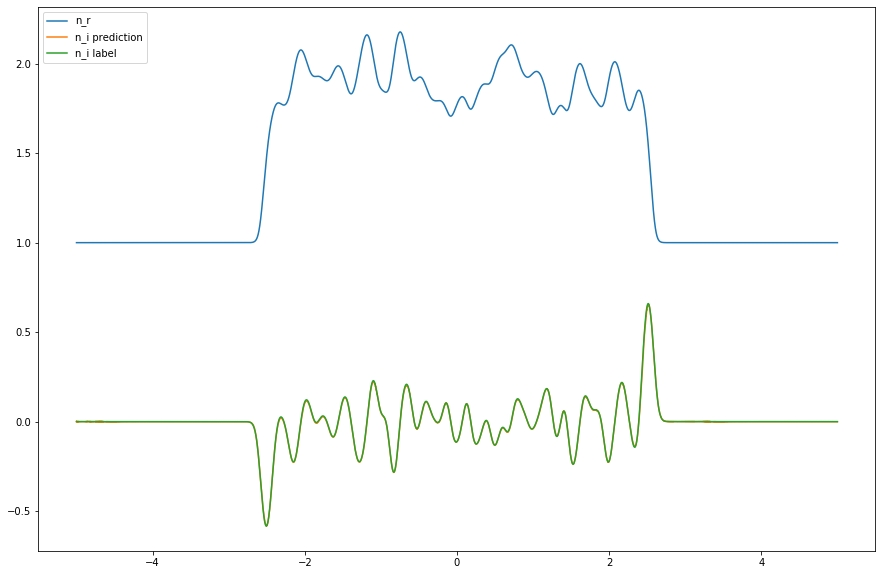

In [26]:
nr, ni, ni_pred, k = plot_prediction(validation_loader, model, grid, 
                                     nr_mean, nr_std, ni_mean, ni_std, 
                                     idx=0, k=None)
plt.savefig(path_plots + which_model + '_Prediction.pdf')

The intensity with the label potential like this...

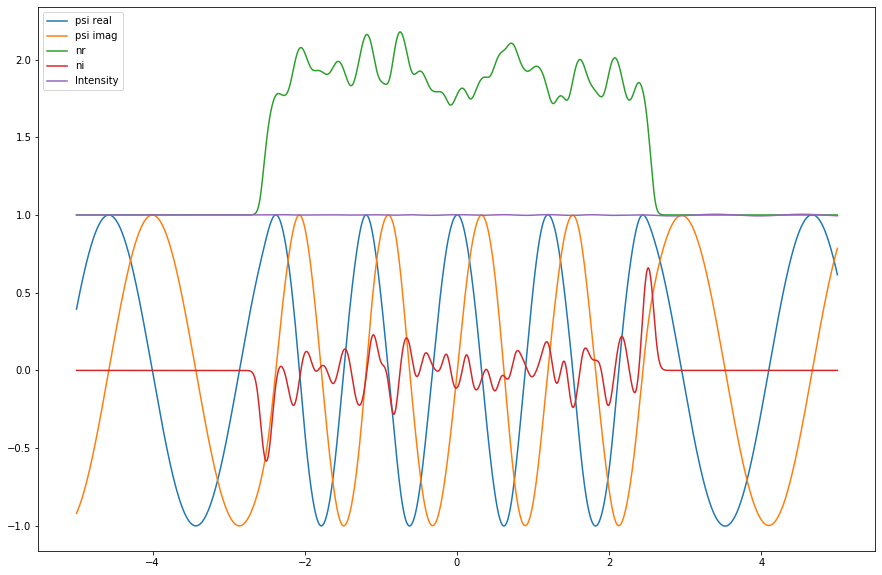

In [27]:
Int = plot_psi(grid, stepsize, n = nr + 1j*ni, Amp = 1, k=k)

And the intensity with the predicted potential like this...

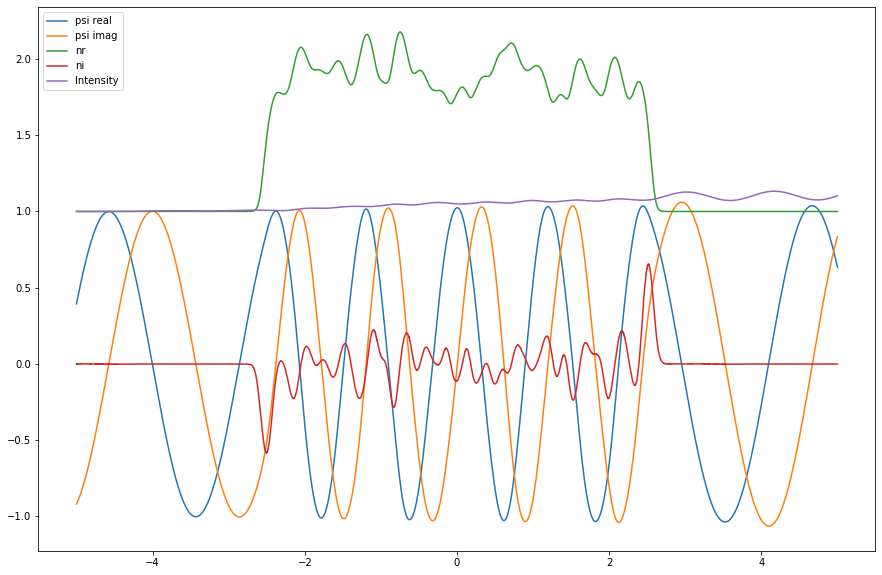

In [28]:
Int_pred = plot_psi(grid, stepsize, n = nr + 1j*ni_pred, Amp = 1, k=k)
plt.savefig(path_plots + which_model + '_CI.pdf')

The differences between the predicted potentials and intensities like this...

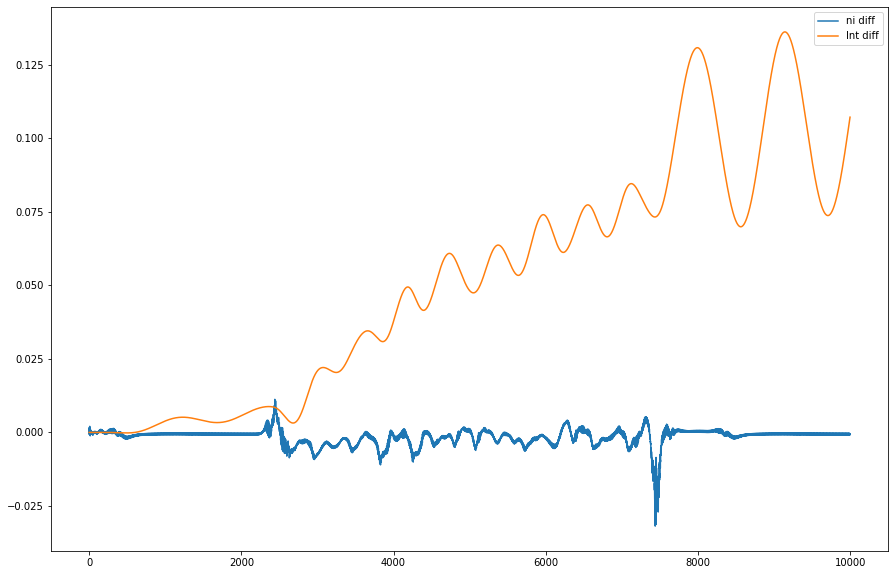

In [29]:
plt.plot(ni_pred-ni, label = 'ni diff')
plt.plot(Int_pred - Int, label = 'Int diff')
plt.legend(loc='upper right')
plt.savefig(path_plots + which_model + '_Diff.pdf')

The label intensity vs the predicted

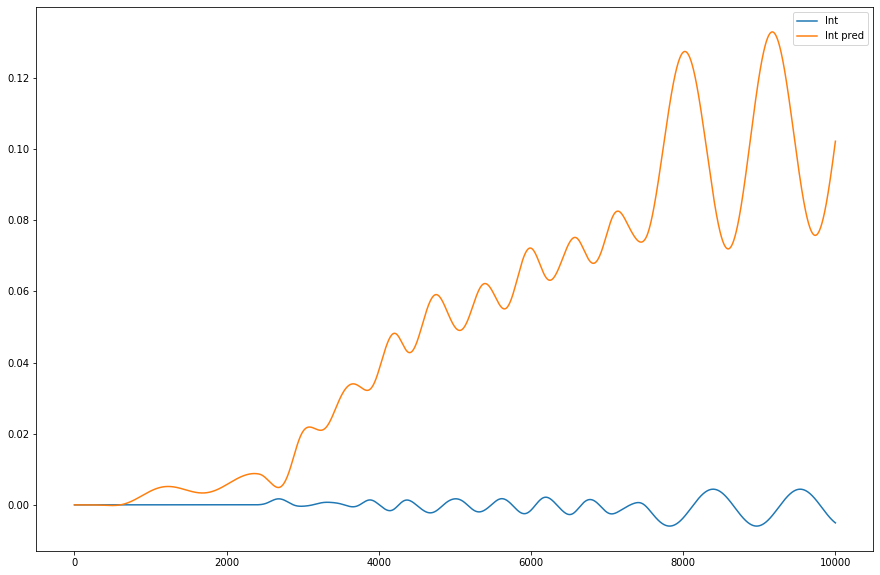

In [30]:
plt.plot(Int -1, label = 'Int')
plt.plot(Int_pred -1, label = 'Int pred')
plt.legend(loc='upper right')

### Special Cases

In [31]:
plt.rcParams['figure.figsize'] = [15,10]

knr:  torch.Size([64, 10001])
ni_pred:  torch.Size([10000])
nr:  torch.Size([10001])
1.7647726843682712


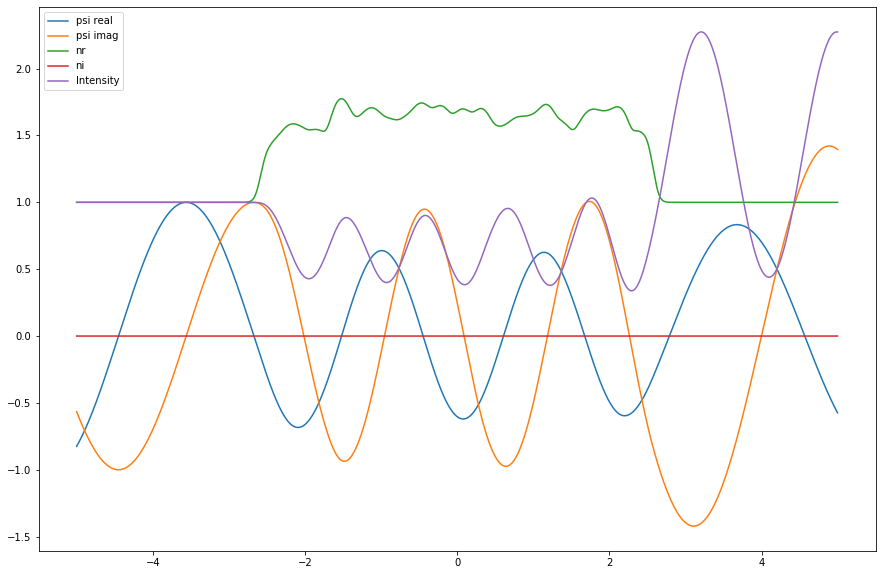

In [32]:
# numerov wave to just nr (what about the intensity? it shouldnt be wave-y)

idx = np.random.randint(8)

item = next(iter(validation_loader))

knr = item['k_n_r']
print('knr: ', knr.size())
ni_pred = model(knr)[idx]
print('ni_pred: ', ni_pred.size())

nr = knr[idx]
print('nr: ', nr.size())

k = DeNorm(knr[idx][0].cpu().numpy(), nr_mean, nr_std)
print(k)
n = DeNorm(nr.cpu().numpy() , nr_mean, nr_std)# + 1j*ni_pred.detach().numpy()
plot_psi(grid, stepsize, n, Amp=1, k=k, plot = True)

plt.savefig(path_plots + '_onlynr.pdf')

### Test

In [12]:
if do_create_test_data:
    generate_init_data_diverse(1000, path = path_test_data, x = grid, dx = stepsize)

Generating Pot Nmbr  0 , Runtime since last:  0.08667230606079102 , Runtime so far:  0.08667206764221191
Generating Pot Nmbr  300 , Runtime since last:  21.960411310195923 , Runtime so far:  22.047083616256714
Generating Pot Nmbr  600 , Runtime since last:  22.288914680480957 , Runtime so far:  44.33599829673767
Generating Pot Nmbr  900 , Runtime since last:  23.01829504966736 , Runtime so far:  67.35429310798645
Generating Pot Nmbr  1200 , Runtime since last:  22.171197414398193 , Runtime so far:  89.5254909992218
Generating Pot Nmbr  1500 , Runtime since last:  21.954957246780396 , Runtime so far:  111.48044872283936
Generating Pot Nmbr  1800 , Runtime since last:  22.34116220474243 , Runtime so far:  133.8216106891632
Generating Pot Nmbr  2100 , Runtime since last:  22.01322317123413 , Runtime so far:  155.83483409881592
Generating Pot Nmbr  2400 , Runtime since last:  22.199772834777832 , Runtime so far:  178.0346074104309
Generating Pot Nmbr  2700 , Runtime since last:  21.6822621

In [33]:
nr_mean_test, nr_std_test, ni_mean_test, ni_std_test = calc_mean_std(3000, path_test_data)

In [34]:
transform_test = transforms.Compose([Normalize((nr_mean_test, ni_mean_test), (nr_std_test, ni_std_test)),
                                    ToTensor(device)
                                   ])

In [35]:
initial_dataset_test = InitialDataset(csv_file = path_test_data + 'k_values.csv', 
                                   root_dir = path_test_data,
                                   transform = transform_test)

In [36]:
test_loader, _ = get_dataloaders(initial_dataset_test, 
                                                  batch_size = 6, 
                                                  validation_split = 0, 
                                                  shuffle_dataset = False, 
                                                  random_seed= 42)

1817
1.4296376705169678


<function matplotlib.pyplot.show(*args, **kw)>

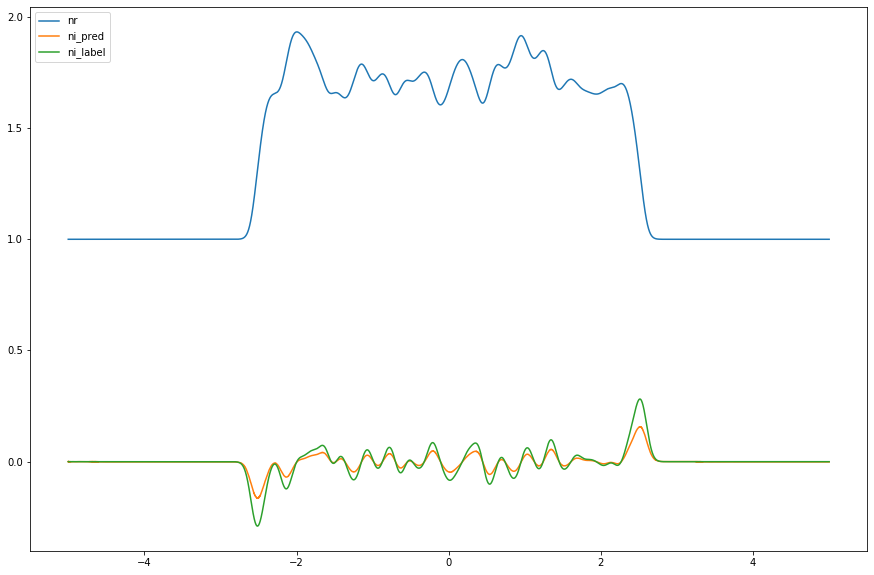

In [55]:
idx = np.random.randint(3000)
print(idx)

data = initial_dataset_test[idx]['k_n_r'].view(1,-1)
out = model(data)
label = initial_dataset_test[idx]['n_i']

criterion = torch.nn.MSELoss()
print(criterion(out[0],label).item() * 8)

plt.plot(grid, DeNorm(data[0][1:].detach().cpu().numpy(),nr_mean_test,nr_std_test), label='nr')
plt.plot(grid, DeNorm(out[0].detach().cpu().numpy(),ni_mean_test,ni_std_test), label = 'ni_pred')
plt.plot(grid, DeNorm(label.detach().cpu().numpy(),ni_mean_test,ni_std_test), label = 'ni_label')
plt.legend(loc='upper left')
plt.show


idx:  3
knr:  tensor([[20.7275, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [14.5152, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [26.9398, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [11.4090, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [17.6214, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [17.6214, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156]],
       device='cuda:0')
real k:  4.999999940677045
new k:  25
knr:  tensor([[73.5322, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [73.5322, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [73.5322, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [73.5322, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [73.5322, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [73.5322, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156]],
       device='cuda:0')
max Int:  1.2345638082407289
min Int:  0.79624320118

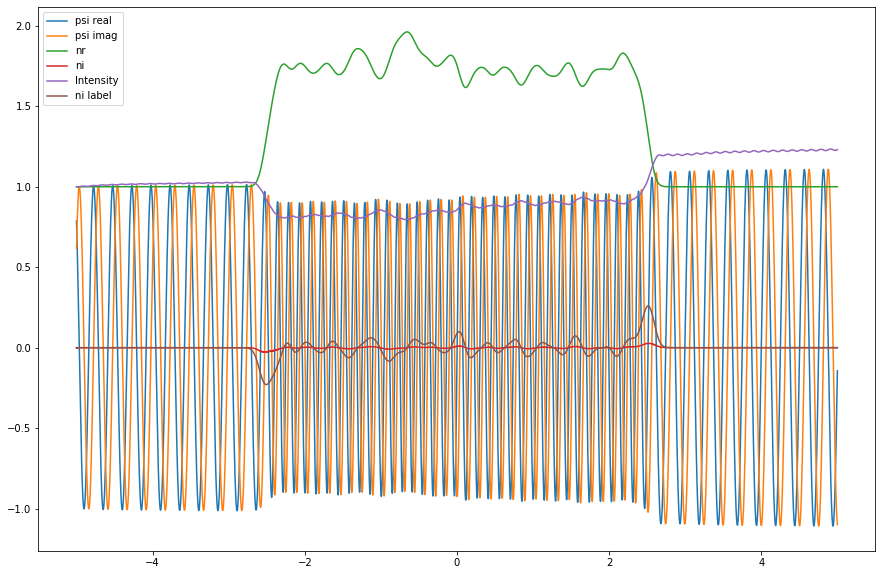

In [80]:
# predict ni for other k - does that work...?

idx = np.random.randint(6)
print('idx: ',idx)

item = next(iter(test_loader))

knr = item['k_n_r']
print('knr: ', knr)

ni = DeNorm(item['n_i'][idx].detach().cpu().numpy(), ni_mean_test, ni_std_test)
k_real = DeNorm(knr[idx][0].detach().cpu().numpy(), nr_mean_test, nr_std_test )
print('real k: ', k_real )

k_new = np.random.randint(1,101) # np.around(k_real)
print('new k: ', k_new)

knr[:,0] = (k_new - nr_mean_test)/nr_std_test # normalize
print('knr: ',knr)

ni_pred = model(knr)[idx]
#print('ni_pred: ', ni_pred.size())

#print('new k normalized: ',knr[idx][0].cpu().numpy())
k = knr[idx][0].cpu().numpy()
#print('new k: ', k*nr_std + nr_mean)
nr = DeNorm(knr[idx].cpu().numpy(), nr_mean_test, nr_std_test)[1:]
ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
n = nr + 1j*ni_pred
Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_new, plot = True)
#Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_real, plot = True)
#plt.plot(grid, ni_pred, label='ni')
plt.plot(grid, ni, label='ni label')
plt.legend(loc='upper left')

plt.savefig(path_plots + which_model + '_differentk.pdf')

print('max Int: ',np.max(Int_pred))
print('min Int: ',np.min(Int_pred))


### Treshold CI Check

In [39]:
# check for all in testset if CI without ni

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros(len(Tresh))

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        
        Int = plot_psi(grid, stepsize, n=nr, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), Tresh[0], over_tresh[0], Tresh[1], over_tresh[1], 
                  Tresh[2], over_tresh[2], Tresh[3], over_tresh[3], Tresh[4], over_tresh[4]))

0/500, 0.5:3.0, 0.2:6.0, 0.1:6.0, 0.05:6.0, 0.03:6.0
10/500, 0.5:38.0, 0.2:66.0, 0.1:66.0, 0.05:66.0, 0.03:66.0
20/500, 0.5:77.0, 0.2:126.0, 0.1:126.0, 0.05:126.0, 0.03:126.0
30/500, 0.5:116.0, 0.2:186.0, 0.1:186.0, 0.05:186.0, 0.03:186.0
40/500, 0.5:152.0, 0.2:246.0, 0.1:246.0, 0.05:246.0, 0.03:246.0
50/500, 0.5:193.0, 0.2:306.0, 0.1:306.0, 0.05:306.0, 0.03:306.0
60/500, 0.5:228.0, 0.2:366.0, 0.1:366.0, 0.05:366.0, 0.03:366.0
70/500, 0.5:264.0, 0.2:426.0, 0.1:426.0, 0.05:426.0, 0.03:426.0
80/500, 0.5:302.0, 0.2:486.0, 0.1:486.0, 0.05:486.0, 0.03:486.0
90/500, 0.5:345.0, 0.2:546.0, 0.1:546.0, 0.05:546.0, 0.03:546.0
100/500, 0.5:382.0, 0.2:606.0, 0.1:606.0, 0.05:606.0, 0.03:606.0
110/500, 0.5:417.0, 0.2:666.0, 0.1:666.0, 0.05:666.0, 0.03:666.0
120/500, 0.5:461.0, 0.2:726.0, 0.1:726.0, 0.05:726.0, 0.03:726.0
130/500, 0.5:502.0, 0.2:786.0, 0.1:786.0, 0.05:786.0, 0.03:786.0
140/500, 0.5:537.0, 0.2:846.0, 0.1:846.0, 0.05:846.0, 0.03:846.0
150/500, 0.5:570.0, 0.2:906.0, 0.1:906.0, 0.05:906.0

[0 1 2 3 4 5]
[1896.0, 1104.0, 0.0, 0.0, 0.0, 0.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


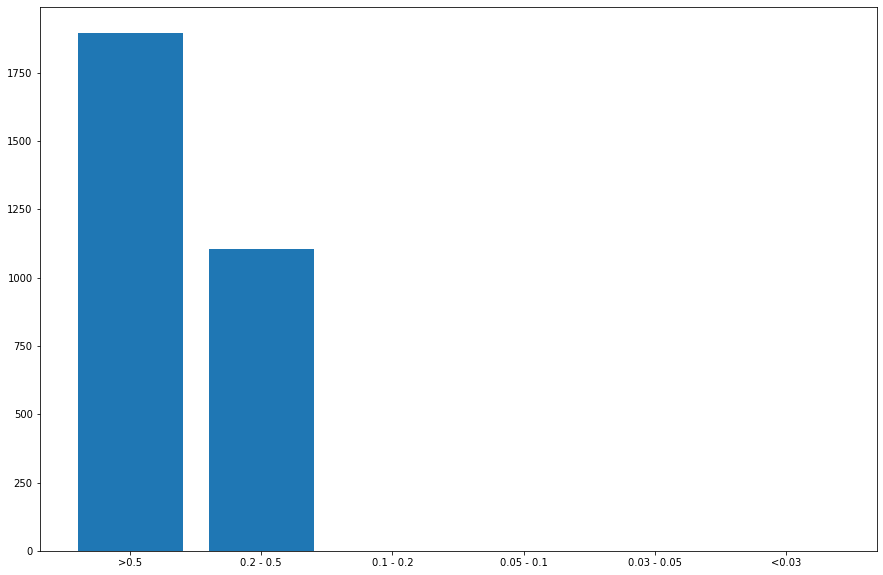

In [40]:
plot_intensity_bars(Tresh, over_tresh, path_plots + 'bars_hermitean.pdf')

In [41]:
# check for all in testset if CI with ni label

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros(len(Tresh))

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni = DeNorm(ni.cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int = plot_psi(grid, stepsize, n=nr + 1j*ni, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), Tresh[0], over_tresh[0], Tresh[1], over_tresh[1], 
                  Tresh[2], over_tresh[2], Tresh[3], over_tresh[3], Tresh[4], over_tresh[4]))

0/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
10/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
20/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:1.0
30/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
40/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
50/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
60/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
70/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
80/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
90/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
100/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
110/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
120/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:2.0
130/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:3.0
140/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:4.0
150/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:5.0
160/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
170/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
180/500, 0.5:0.0, 0.2

[0 1 2 3 4 5]
[0.0, 0.0, 0.0, 0.0, 32.0, 2968.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


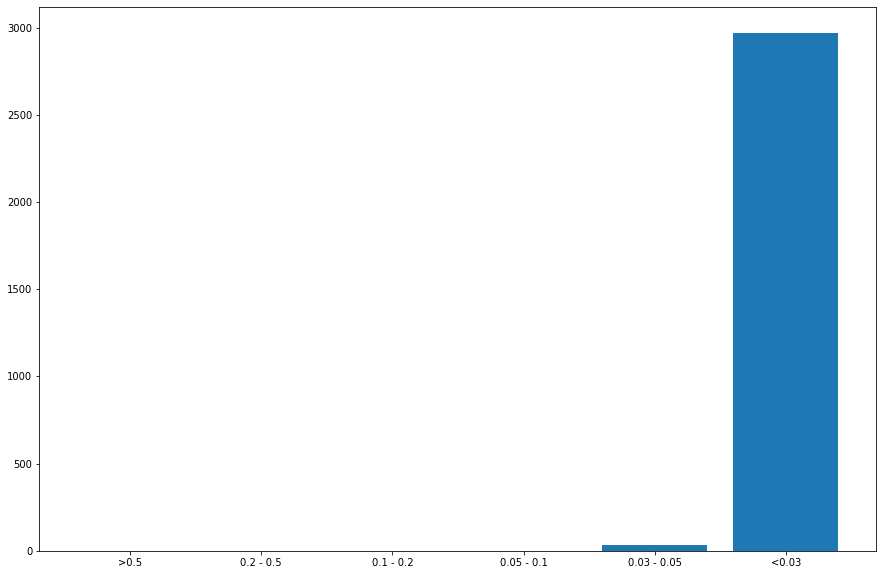

In [42]:
plot_intensity_bars(Tresh, over_tresh, path_plots + 'bars_label.pdf')

In [43]:
# check for all in testset if CI with ni pred

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
nipred_over_tresh = np.zeros([len(Tresh), 10]) #tresh, k_real
nipred_how_many_k = np.zeros(10)

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        k = int(np.around(DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)))
        
        nipred_how_many_k[k-1] += 1
        
        ni_pred = model(knr.view(1,-1))[0]
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int_pred = plot_psi(grid, stepsize, n=nr + 1j*ni_pred, Amp=Amp, k=k, plot = False)
        
        rel_err = np.max((np.abs(Int_pred - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                nipred_over_tresh[i, k-1] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), np.sum(Tresh[0]), np.sum(nipred_over_tresh[0]), 
            np.sum(Tresh[1]), np.sum(nipred_over_tresh[1]), 
            np.sum(Tresh[2]), np.sum(nipred_over_tresh[2]), 
            np.sum(Tresh[3]), np.sum(nipred_over_tresh[3]), 
            np.sum(Tresh[4]), np.sum(nipred_over_tresh[4])))


0/500, 0.5:3.0, 0.2:5.0, 0.1:6.0, 0.05:6.0, 0.03:6.0
10/500, 0.5:15.0, 0.2:52.0, 0.1:66.0, 0.05:66.0, 0.03:66.0
20/500, 0.5:28.0, 0.2:100.0, 0.1:126.0, 0.05:126.0, 0.03:126.0
30/500, 0.5:44.0, 0.2:153.0, 0.1:186.0, 0.05:186.0, 0.03:186.0
40/500, 0.5:64.0, 0.2:201.0, 0.1:246.0, 0.05:246.0, 0.03:246.0
50/500, 0.5:75.0, 0.2:237.0, 0.1:306.0, 0.05:306.0, 0.03:306.0
60/500, 0.5:88.0, 0.2:286.0, 0.1:366.0, 0.05:366.0, 0.03:366.0
70/500, 0.5:98.0, 0.2:335.0, 0.1:426.0, 0.05:426.0, 0.03:426.0
80/500, 0.5:110.0, 0.2:384.0, 0.1:486.0, 0.05:486.0, 0.03:486.0
90/500, 0.5:125.0, 0.2:430.0, 0.1:546.0, 0.05:546.0, 0.03:546.0
100/500, 0.5:136.0, 0.2:476.0, 0.1:606.0, 0.05:606.0, 0.03:606.0
110/500, 0.5:157.0, 0.2:531.0, 0.1:666.0, 0.05:666.0, 0.03:666.0
120/500, 0.5:165.0, 0.2:578.0, 0.1:726.0, 0.05:726.0, 0.03:726.0
130/500, 0.5:176.0, 0.2:618.0, 0.1:786.0, 0.05:786.0, 0.03:786.0
140/500, 0.5:192.0, 0.2:663.0, 0.1:846.0, 0.05:846.0, 0.03:846.0
150/500, 0.5:198.0, 0.2:707.0, 0.1:906.0, 0.05:906.0, 0.0

[0 1 2 3 4 5]
[625.0, 1662.0, 713.0, 0.0, 0.0, 0.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


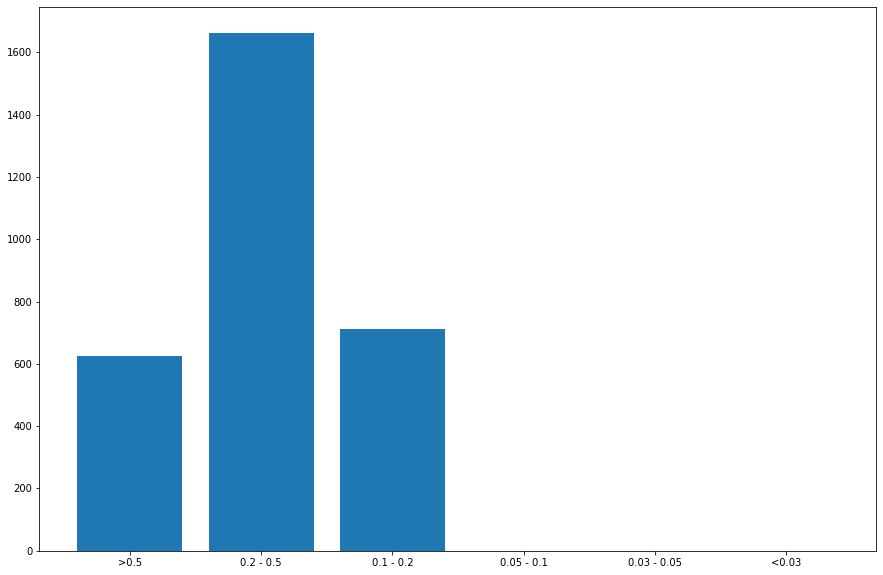

In [44]:
nipred_sum_over_tresh = np.zeros(len(nipred_over_tresh))
for i in range(len(nipred_sum_over_tresh)):
    nipred_sum_over_tresh[i] = int(np.sum(nipred_over_tresh[i]))

plot_intensity_bars(Tresh, nipred_sum_over_tresh, path_plots + which_model + '_bars_prediction.pdf')

0.5 0.20971095455153801
0.2 0.7651125707538527
0.1 1.0
0.05 1.0
0.03 1.0


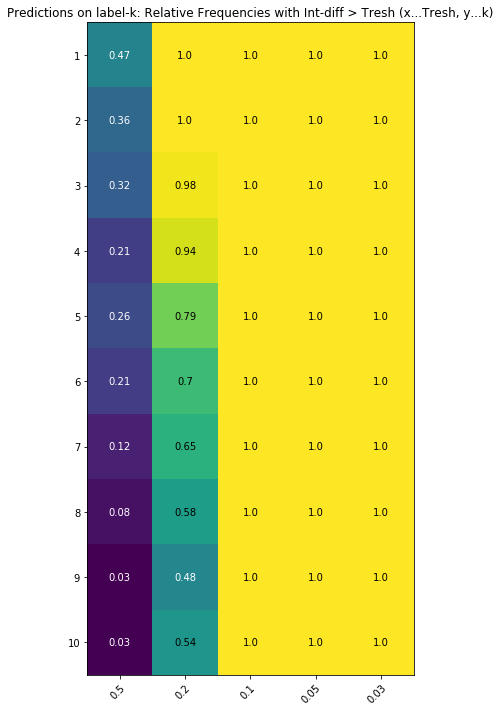

In [45]:
# map for the relative frequencies against the treshhold

k_real = list(range(1,11))

nipred_rel_freq = np.copy(nipred_over_tresh)

for i in range(len(nipred_rel_freq)):
    nipred_rel_freq[i,:] = nipred_rel_freq[i,:]/nipred_how_many_k
    print(Tresh[i], np.mean(nipred_rel_freq[i,:]))
    
nipred_rel_freq = np.transpose(nipred_rel_freq) 

textcolors=["black", "white"]
textcolor_tresh = np.max(nipred_rel_freq)/2

fig, ax = plt.subplots()
im = ax.imshow(nipred_rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(Tresh)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(Tresh)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(Tresh)):
        text = ax.text(j, i, np.around(nipred_rel_freq[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(nipred_rel_freq[i,j] < textcolor_tresh)])

ax.set_title("Predictions on label-k: Relative Frequencies with Int-diff > Tresh (x...Tresh, y...k)")
fig.tight_layout()
plt.savefig(path_plots + which_model + '_nipred_RelFreq_gTresh.pdf')
plt.show()

In [46]:
# check for all in testset with random k if CI

Amp = 1
Tresh = [0.5,0.2,0.1,0.05,0.03]
over_tresh = np.zeros([len(Tresh), 10, 10]) #tresh, k_real, k_new
how_many_k = np.zeros([10,10]) # k_real, k_new

for j,batch in enumerate(test_loader):
    
    knrs = batch['k_n_r']
    nis = batch['n_i']
    for knr,ni in zip(knrs,nis):
        
        k_real = int(np.around(DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test, nr_std_test)))
        k_new = np.random.randint(1,11)
        #print(k_real, k_new)
        
        
        how_many_k[k_real-1, k_new-1] += 1        
        
        knr[0] = (k_new - nr_mean_test) / nr_std_test
        ni_pred = model(knr.view(1,-1))[0]
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int_pred = plot_psi(grid, stepsize, n=nr + 1j*ni_pred, Amp=Amp, k=k_new, plot = False)
        
        rel_err = np.max((np.abs(Int_pred - Amp)/Amp))
        
        for i,tr in enumerate(Tresh):
            if  rel_err > tr:
                over_tresh[i, k_real-1, k_new-1] += 1
    if j%10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j,len(test_loader), np.sum(Tresh[0]), np.sum(over_tresh[0]), 
            np.sum(Tresh[1]), np.sum(over_tresh[1]), 
            np.sum(Tresh[2]), np.sum(over_tresh[2]), 
            np.sum(Tresh[3]), np.sum(over_tresh[3]), 
            np.sum(Tresh[4]), np.sum(over_tresh[4])))
        
    #break

0/500, 0.5:1.0, 0.2:5.0, 0.1:6.0, 0.05:6.0, 0.03:6.0
10/500, 0.5:15.0, 0.2:51.0, 0.1:66.0, 0.05:66.0, 0.03:66.0
20/500, 0.5:33.0, 0.2:97.0, 0.1:126.0, 0.05:126.0, 0.03:126.0
30/500, 0.5:49.0, 0.2:140.0, 0.1:186.0, 0.05:186.0, 0.03:186.0
40/500, 0.5:68.0, 0.2:186.0, 0.1:246.0, 0.05:246.0, 0.03:246.0
50/500, 0.5:85.0, 0.2:236.0, 0.1:306.0, 0.05:306.0, 0.03:306.0
60/500, 0.5:107.0, 0.2:285.0, 0.1:366.0, 0.05:366.0, 0.03:366.0
70/500, 0.5:119.0, 0.2:330.0, 0.1:426.0, 0.05:426.0, 0.03:426.0
80/500, 0.5:139.0, 0.2:382.0, 0.1:486.0, 0.05:486.0, 0.03:486.0
90/500, 0.5:156.0, 0.2:426.0, 0.1:546.0, 0.05:546.0, 0.03:546.0
100/500, 0.5:169.0, 0.2:468.0, 0.1:606.0, 0.05:606.0, 0.03:606.0
110/500, 0.5:179.0, 0.2:521.0, 0.1:666.0, 0.05:666.0, 0.03:666.0
120/500, 0.5:191.0, 0.2:566.0, 0.1:726.0, 0.05:726.0, 0.03:726.0
130/500, 0.5:206.0, 0.2:615.0, 0.1:786.0, 0.05:786.0, 0.03:786.0
140/500, 0.5:222.0, 0.2:661.0, 0.1:846.0, 0.05:846.0, 0.03:846.0
150/500, 0.5:237.0, 0.2:708.0, 0.1:906.0, 0.05:906.0, 0.

[0 1 2 3 4 5]
[765.0, 1586.0, 649.0, 0.0, 0.0, 0.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


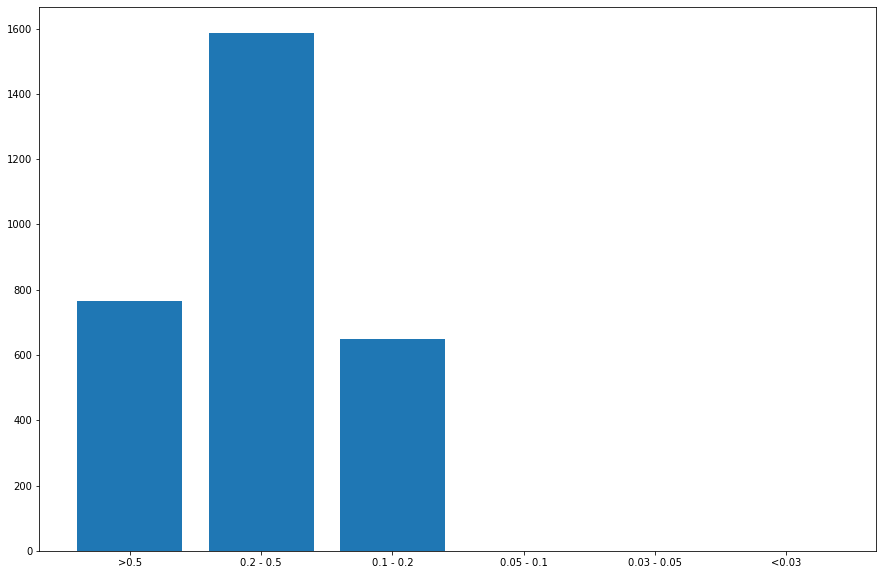

In [47]:
sum_over_tresh = np.zeros(len(over_tresh))
for i in range(len(sum_over_tresh)):
    sum_over_tresh[i] = int(np.sum(over_tresh[i]))

plot_intensity_bars(Tresh, sum_over_tresh, path_plots + which_model + '_bars_differentk.pdf')

3000.0
30.0


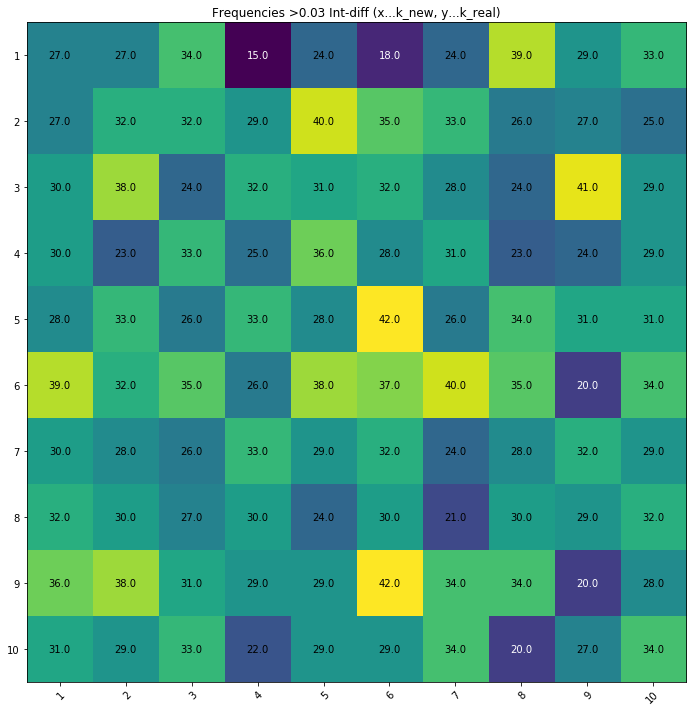

In [48]:
# map for the frequencies

tres_ind = 4

k_real = list(range(1,11))
k_new = list(range(1,11))

freq = over_tresh[tres_ind]
print(np.sum(freq))
print(np.mean(freq))

textcolors=["black", "white"]
textcolor_tresh = np.max(freq)/2

fig, ax = plt.subplots()
im = ax.imshow(freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, freq[i, j],
                       ha="center", va="center",
                       color=textcolors[int(freq[i,j] < textcolor_tresh)])

ax.set_title("Frequencies >{} Int-diff (x...k_new, y...k_real)".format(Tresh[tres_ind]))
fig.tight_layout()
plt.show()

3000.0
30.0


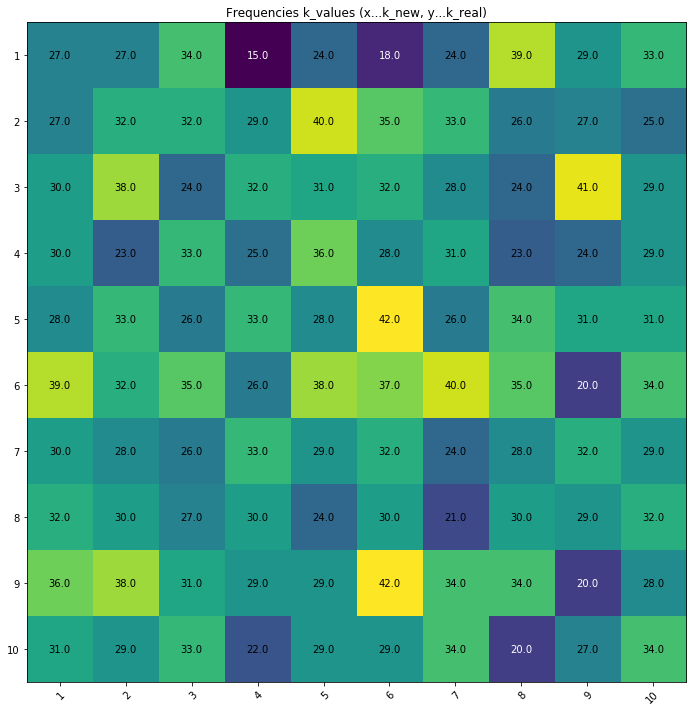

In [49]:
# map for the k values

k_real = list(range(1,11))
k_new = list(range(1,11))

freq_k = how_many_k
print(np.sum(freq_k))
print(np.mean(freq_k))

textcolors=["black", "white"]
textcolor_tresh = np.max(freq_k)/2

fig, ax = plt.subplots()
im = ax.imshow(freq_k)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, np.around(freq_k[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(freq_k[i,j] < textcolor_tresh)])

ax.set_title("Frequencies k_values (x...k_new, y...k_real)")
fig.tight_layout()
plt.show()

3000.0
1.0


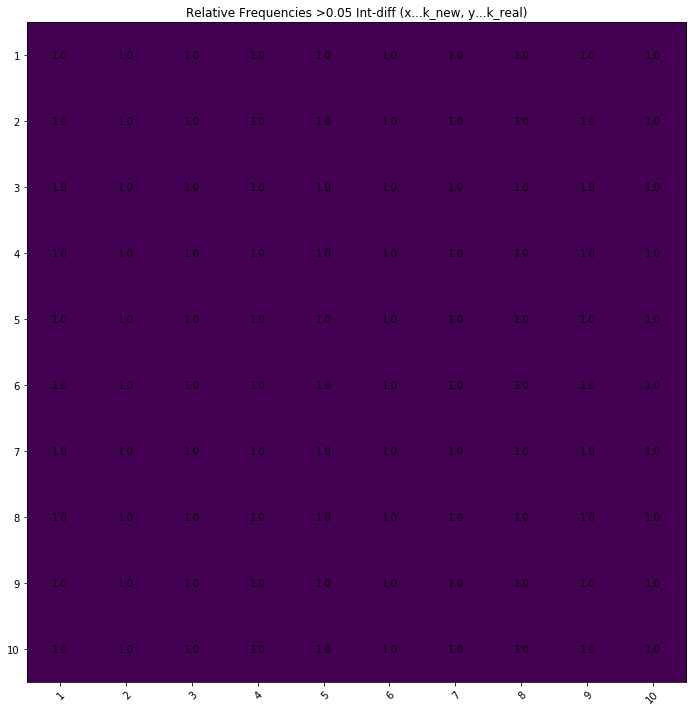

In [86]:
# map for the relative frequencies

tres_ind = 3 # [0.5, 0.2, 0.1, 0.05, 0.03]

k_real = list(range(1,11))
k_new = list(range(1,11))

rel_freq = over_tresh[tres_ind]/how_many_k
print(np.sum(over_tresh[tres_ind]))
print(np.mean(rel_freq))

textcolors=["black", "white"]
textcolor_tresh = np.max(rel_freq)/2

fig, ax = plt.subplots()
im = ax.imshow(rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j, i, np.around(rel_freq[i, j], decimals=2),
                       ha="center", va="center",
                       color=textcolors[int(rel_freq[i,j] < textcolor_tresh)])

ax.set_title("Relative Frequencies >{} Int-diff (x...k_new, y...k_real)".format(Tresh[tres_ind]))
fig.tight_layout()
plt.savefig(path_plots + which_model + '_RelFreq_Int_' + str(Tresh[tres_ind]) + '.pdf')
plt.show()